<a href="https://colab.research.google.com/github/Maicol54/TFM---Eficiencia-y-Escalabilidad-de-Modelos-para-la-Aprobacion-de-Creditos-Bancarios-/blob/main/TFM_Eficiencia_y_Escalabilidad_de_Modelos_para_la_Aprobacion_de_Creditos_Bancarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIVERSIDAD INTERNACIONAL DE VALENCIA (VIU)

# MASTER UNIVERSITARIO EN BIG DATA Y CIENCIA DE DATOS

# TFM - EFICIENCIA Y ESCALABILIDAD DE MODELOS PARA LA APROBACIÓN DE CRÉDITOS BANCARIOS

# ALUMNO: ARDILA AMADO, MAICOL ANDRES

# D.N.I.: 1019136257

# DIRECTOR: NATALINI, FABIO

# CONVOCATORIA: SEGUNDA

---
# Imports Generales
---

In [ ]:
# Imports generales

import pandas as pd
import io
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sklearn.metrics
import time
from sklearn.tree import DecisionTreeClassifier
from subprocess import check_call
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import Image as PImage
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
!pip install -q -U keras-tuner
!pip install dalex
!pip install dalex plotly
import dalex as dx
import kerastuner as kt
from tensorflow.keras import regularizers
from keras.utils import plot_model
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import drive
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
from sklearn.utils import compute_class_weight
%matplotlib inline
pd.options.display.max_columns = None

BASE_FOLDER = "/content/drive/MyDrive/TFM Maicol Ardila/"
drive.mount('/content/drive')

# Funcion para realizar la carga de archivos

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1045995 sha256=6c6872668b49478f486a9bf115292e292caf636504eb8ec5758b9e47c400483d
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


<ipython-input-1-2724261cf90a>:38: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Mounted at /content/drive


---
# Carga de los Datos
---

In [ ]:
credit = upload_files()
print(credit.shape)
credit.head()

Saving credit.csv to credit.csv
User uploaded file "credit.csv" with length 93763 bytes
(1000, 17)


checking_balance  months_loan_duration credit_history               purpose  \
0           < 0 DM                     6       critical  furniture/appliances   
1       1 - 200 DM                    48           good  furniture/appliances   
2          unknown                    12       critical             education   
3           < 0 DM                    42           good  furniture/appliances   
4           < 0 DM                    24           poor                   car   

   amount savings_balance employment_duration  percent_of_income  \
0    1169         unknown           > 7 years                  4   
1    5951        < 100 DM         1 - 4 years                  2   
2    2096        < 100 DM         4 - 7 years                  2   
3    7882        < 100 DM         4 - 7 years                  2   
4    4870        < 100 DM         1 - 4 years                  3   

   years_at_residence  age other_credit housing  existing_loans_count  \
0                   4   67         none     own                     2   
1                   2   22         none     own                     1   
2                   3   49         none     own                     1   
3                   4   45         none   other                     1   
4                   4   53         none   other                     2   

         job  dependents phone default  
0    skilled           1   yes      no  
1    skilled           1    no     yes  
2  unskilled           2    no      no  
3    skilled           2    no      no  
4    skilled           2    no     yes

---
# Preprocesado de los Datos
---

In [ ]:
credit['percent_of_income'] = credit['percent_of_income'].astype(str)

In [ ]:
dummies = pd.get_dummies(credit[['checking_balance', 'credit_history', 'purpose', 'savings_balance',
                                 'employment_duration', 'percent_of_income', 'other_credit', 'housing', 'job',
                                 'phone']])
dummies

checking_balance_1 - 200 DM  checking_balance_< 0 DM  \
0                              0                        1   
1                              1                        0   
2                              0                        0   
3                              0                        1   
4                              0                        1   
..                           ...                      ...   
995                            0                        0   
996                            0                        1   
997                            0                        0   
998                            0                        1   
999                            1                        0   

     checking_balance_> 200 DM  checking_balance_unknown  \
0                            0                         0   
1                            0                         0   
2                            0                         1   
3                            0                         0   
4                            0                         0   
..                         ...                       ...   
995                          0                         1   
996                          0                         0   
997                          0                         1   
998                          0                         0   
999                          0                         0   

     credit_history_critical  credit_history_good  credit_history_perfect  \
0                          1                    0                       0   
1                          0                    1                       0   
2                          1                    0                       0   
3                          0                    1                       0   
4                          0                    0                       0   
..                       ...                  ...                     ...   
995                        0                    1                       0   
996                        0                    1                       0   
997                        0                    1                       0   
998                        0                    1                       0   
999                        1                    0                       0   

     credit_history_poor  credit_history_very good  purpose_business  \
0                      0                         0                 0   
1                      0                         0                 0   
2                      0                         0                 0   
3                      0                         0                 0   
4                      1                         0                 0   
..                   ...                       ...               ...   
995                    0                         0                 0   
996                    0                         0                 0   
997                    0                         0                 0   
998                    0                         0                 0   
999                    0                         0                 0   

     purpose_car  purpose_car0  purpose_education  \
0              0             0                  0   
1              0             0                  0   
2              0             0                  1   
3              0             0                  0   
4              1             0                  0   
..           ...           ...                ...   
995            0             0                  0   
996            1             0                  0   
997            0             0                  0   
998            0             0                  0   
999            1             0                  0   

     purpose_furniture/appliances  purpose_renovations  \
0                               1                    0   
1       

In [ ]:
credit_2 = pd.merge(credit.drop(['checking_balance', 'credit_history', 'purpose', 'savings_balance',
                                 'employment_duration', 'percent_of_income', 'other_credit', 'housing', 'job',
                                 'phone'], axis = 'columns'), dummies, left_index=True, right_index=True)
credit_2[['default']] = np.where (credit_2[['default']]=='yes', 1,0)
credit_2.head()

months_loan_duration  amount  years_at_residence  age  \
0                     6    1169                   4   67   
1                    48    5951                   2   22   
2                    12    2096                   3   49   
3                    42    7882                   4   45   
4                    24    4870                   4   53   

   existing_loans_count  dependents  default  checking_balance_1 - 200 DM  \
0                     2           1        0                            0   
1                     1           1        1                            1   
2                     1           2        0                            0   
3                     1           2        0                            0   
4                     2           2        1                            0   

   checking_balance_< 0 DM  checking_balance_> 200 DM  \
0                        1                          0   
1                        0                          0   
2                        0                          0   
3                        1                          0   
4                        1                          0   

   checking_balance_unknown  credit_history_critical  credit_history_good  \
0                         0                        1                    0   
1                         0                        0                    1   
2                         1                        1                    0   
3                         0                        0                    1   
4                         0                        0                    0   

   credit_history_perfect  credit_history_poor  credit_history_very good  \
0                       0                    0                         0   
1                       0                    0                         0   
2                       0                    0                         0   
3                       0                    0                         0   
4                       0                    1                         0   

   purpose_business  purpose_car  purpose_car0  purpose_education  \
0                 0            0             0                  0   
1                 0            0             0                  0   
2                 0            0             0                  1   
3                 0            0             0                  0   
4                 0            1             0                  0   

   purpose_furniture/appliances  purpose_renovations  \
0                             1                    0   
1                             1                    0   
2                             0                    0   
3                             1                    0   
4                             0                    0   

   savings_balance_100 - 500 DM  savings_balance_500 - 1000 DM  \
0                             0                              0   
1                             0                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   

   savings_balance_< 100 DM  savings_balance_> 1000 DM  \
0                         0                          0   
1                         1                          0   
2                         1                          0   
3                         1                          0   
4                         1                          0   

   savings_balance_unknown  employment_duration_1 - 4 years  \
0                        1                                0   
1                        0                                1   
2                        0                                0   
3                        0                                0   
4                        0                                1   

   employment_duration_4 - 7 years  emp

In [ ]:
credit_2.columns = ['months_loan_duration', 'amount', 'years_at_residence', 'age', 'existing_loans_count',
                   'dependents', 'default', 'checking_balance_1 - 200 DM', 'checking_balance_ 0 DM',
                   'checking_balance_ 200 DM', 'checking_balance_unknown', 'credit_history_critical',
                   'credit_history_good', 'credit_history_perfect', 'credit_history_poor',
                   'credit_history_very good', 'purpose_business', 'purpose_car', 'purpose_car0',
                   'purpose_education', 'purpose_furniture/appliances', 'purpose_renovations',
                   'savings_balance_100 - 500 DM', 'savings_balance_500 - 1000 DM', 'savings_balance_ 100 DM',
                   'savings_balance_ 1000 DM', 'savings_balance_unknown', 'employment_duration_1 - 4 years',
                   'employment_duration_4 - 7 years', 'employment_duration_ 1 year',
                   'employment_duration_ 7 years', 'employment_duration_unemployed', 'percent_of_income_1',
                   'percent_of_income_2', 'percent_of_income_3', 'percent_of_income_4', 'other_credit_bank',
                   'other_credit_none', 'other_credit_store', 'housing_other', 'housing_own', 'housing_rent',
                   'job_management', 'job_skilled', 'job_unemployed', 'job_unskilled', 'phone_no', 'phone_yes']

---
## Division del conjunto de Datos (entrenamiento y test)
---

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(credit_2.drop(columns=['default']),
                                                    credit_2['default'], test_size=0.2, random_state=0)

---
# Modelamiento de los Datos
---

---
## Regresion Logistica
---

In [ ]:
reg_log = linear_model.LogisticRegression()
reg_log.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

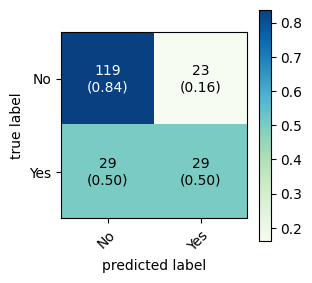

In [ ]:
predictions_log = reg_log.predict(x_test)
score_log = reg_log.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_log),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, reg_log.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.80      0.84      0.82       142
         yes       0.56      0.50      0.53        58

    accuracy                           0.74       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.73      0.74      0.74       200



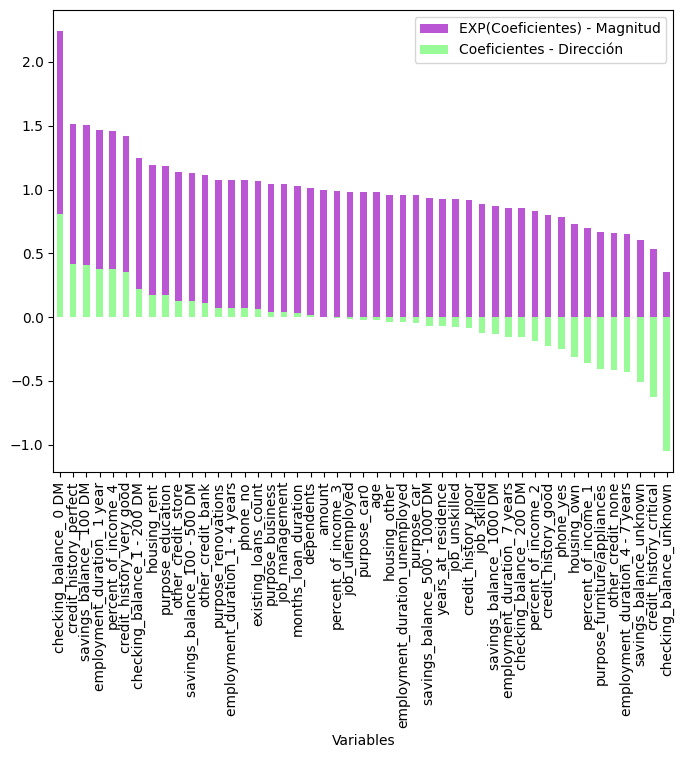

In [ ]:
coefs = pd.DataFrame(reg_log.coef_).transpose()
coefs.index = x_train.columns.values
coefs.columns = ['Coeficientes - Dirección']
coefs['EXP(Coeficientes) - Magnitud'] = np.exp(coefs['Coeficientes - Dirección'])
coefs = coefs.sort_values('EXP(Coeficientes) - Magnitud', ascending = False)
plt.xlabel('Variables')
coefs['EXP(Coeficientes) - Magnitud'].plot(kind='bar', figsize=(8,6), color='#BA55D3')
coefs['Coeficientes - Dirección'].plot(kind='bar', figsize=(8,6), color='#98FB98')
plt.legend()

---
## Arbol de Decision
---

---
### Optimizacion de hiperparametros
---

---
#### Random Search
---

In [ ]:
param_dist_tree = {"min_samples_leaf": np.arange(1, 10, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "max_depth": np.arange(1, 20, 1),
              "random_state": np.arange(1, 30, 1),
            }

arbol = DecisionTreeClassifier(random_state = 0)

rnd_tree = RandomizedSearchCV(estimator = arbol, param_distributions = param_dist_tree,
                               n_iter = 100, cv = 5, random_state=0, n_jobs = -1, scoring ='f1')

rnd_tree.fit(X = x_train, y = y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'random_state': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   random_state=0, scoring='f1')

In [ ]:
rnd_tree.best_params_

{'random_state': 12,
 'min_samples_leaf': 1,
 'max_depth': 17,
 'criterion': 'gini'}

---
#### Grid Search
---

In [ ]:
param_dist_tree_2 = {"min_samples_leaf": np.arange(1, 4, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "max_depth": np.arange(16, 20, 1),
              "random_state": np.arange(9, 15, 1),
            }
arbol_2 = DecisionTreeClassifier(random_state = 0)

grid_tree = GridSearchCV(estimator = arbol_2, param_grid= param_dist_tree_2, cv=5, scoring ='f1')


grid_tree.fit(X = x_train, y = y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([16, 17, 18, 19]),
                         'min_samples_leaf': array([1, 2, 3]),
                         'random_state': array([ 9, 10, 11, 12, 13, 14])},
             scoring='f1')

---
### Creacion del Modelo
---

In [ ]:
Arbol_rnd = rnd_tree.best_estimator_

Arbol_rnd.fit( X = x_train, y = y_train)

DecisionTreeClassifier(max_depth=17, random_state=12)

In [ ]:
Arbol_grid = grid_tree.best_estimator_

Arbol_grid.fit( X = x_train, y = y_train)

DecisionTreeClassifier(max_depth=17, random_state=12)

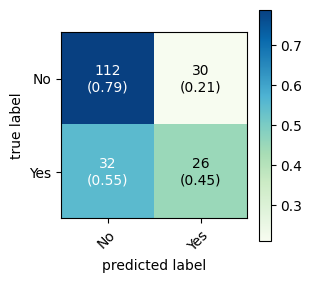

In [ ]:
predictions_arbol_rnd  = Arbol_rnd.predict(X=x_test)
score_arbol_rnd = Arbol_rnd.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_arbol_rnd),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, Arbol_rnd.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.78      0.79      0.78       142
         yes       0.46      0.45      0.46        58

    accuracy                           0.69       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.69      0.69      0.69       200



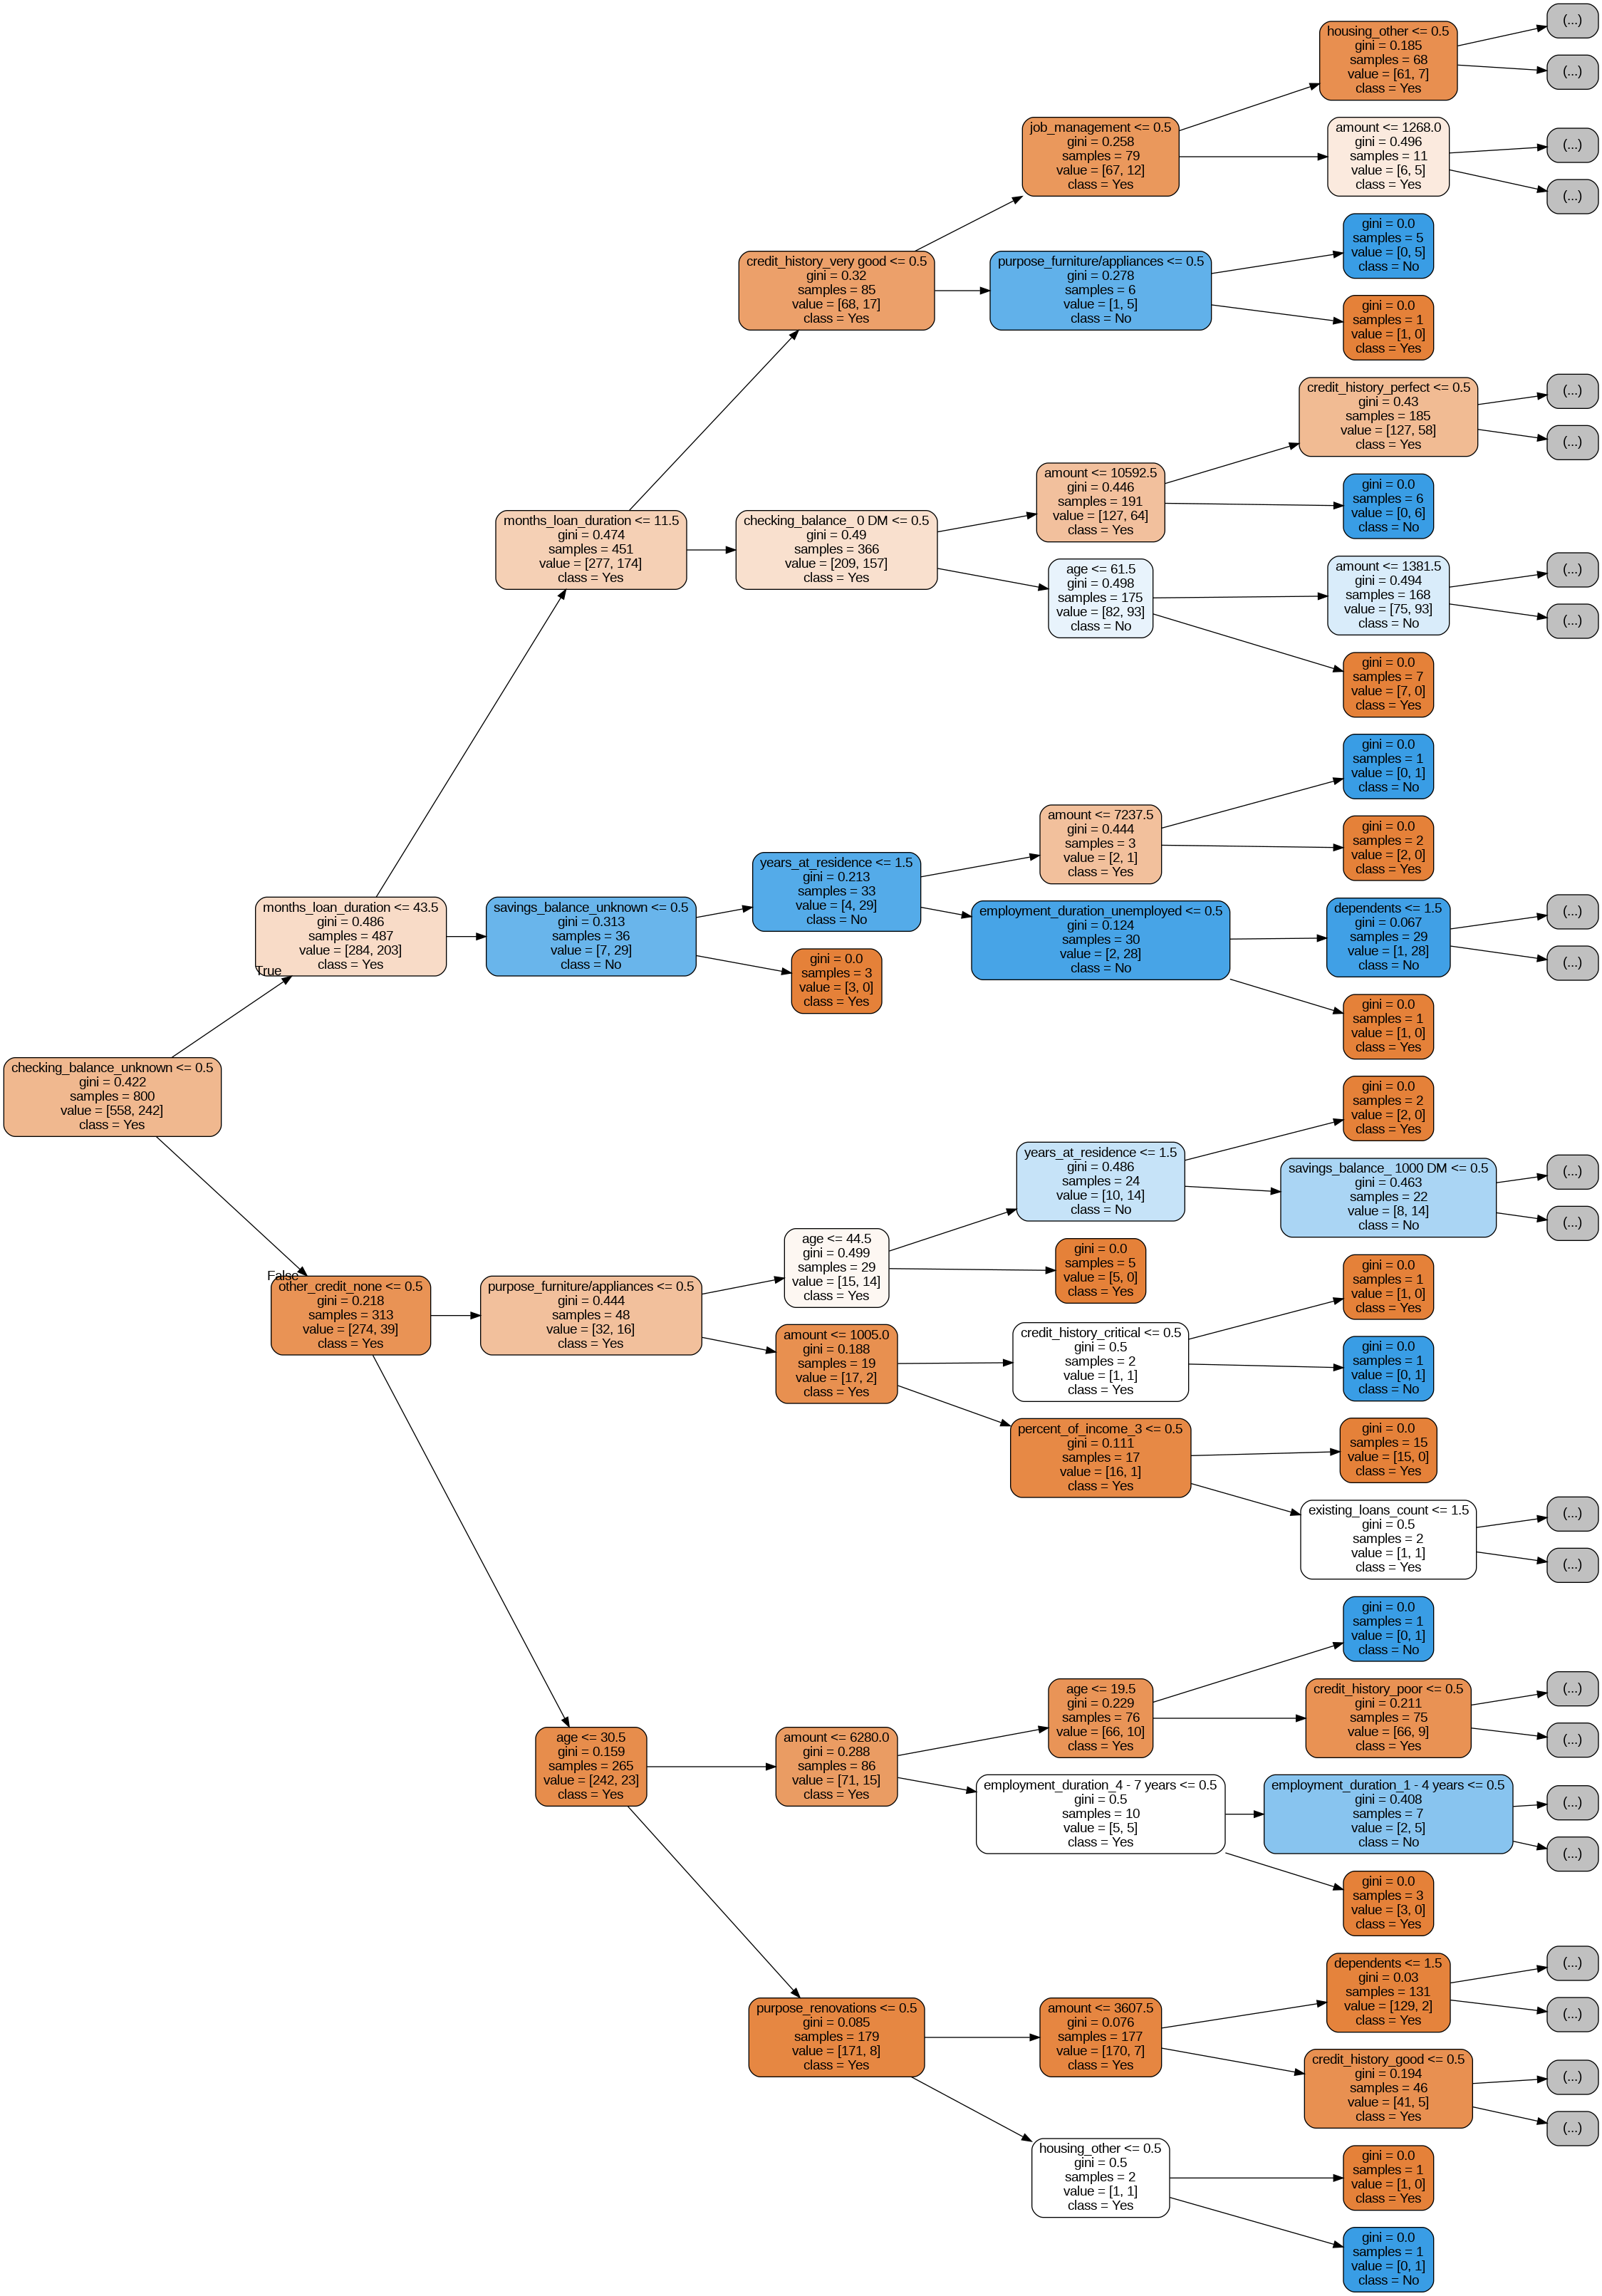

In [ ]:
# Exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(Arbol_rnd,
                              out_file=f,
                              max_depth=5,
                              rotate=True,
                              impurity = True,
                              feature_names = list(credit_2.drop(['default'], axis ='columns')),
                              class_names = ['Yes', 'No'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

---
### Importancia de las Variables
---

In [ ]:
Arbol = DecisionTreeClassifier(random_state=12)

Arbol.fit( X = x_train, y = y_train)

DecisionTreeClassifier(random_state=12)

<Axes: >

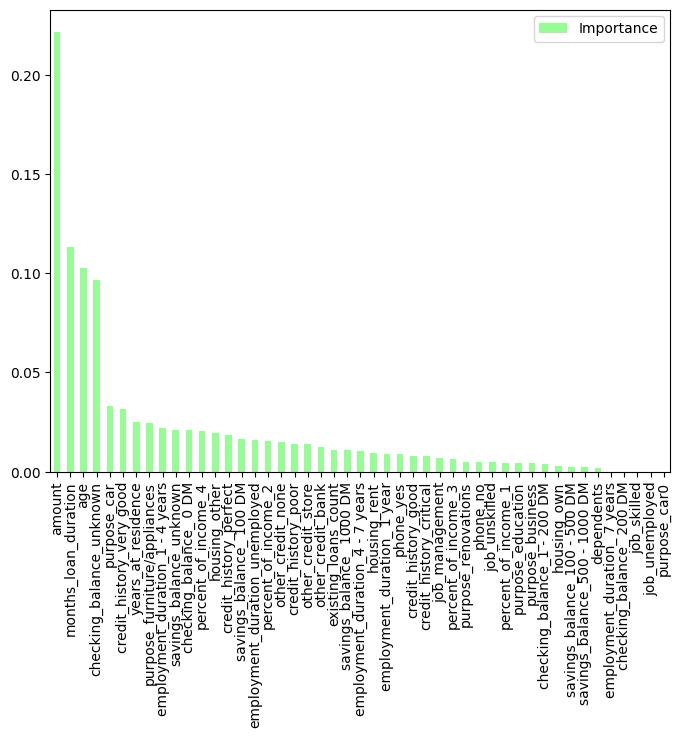

In [ ]:
fi = Arbol.feature_importances_
feat_importances = pd.DataFrame(Arbol.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6), color='#98FB98')

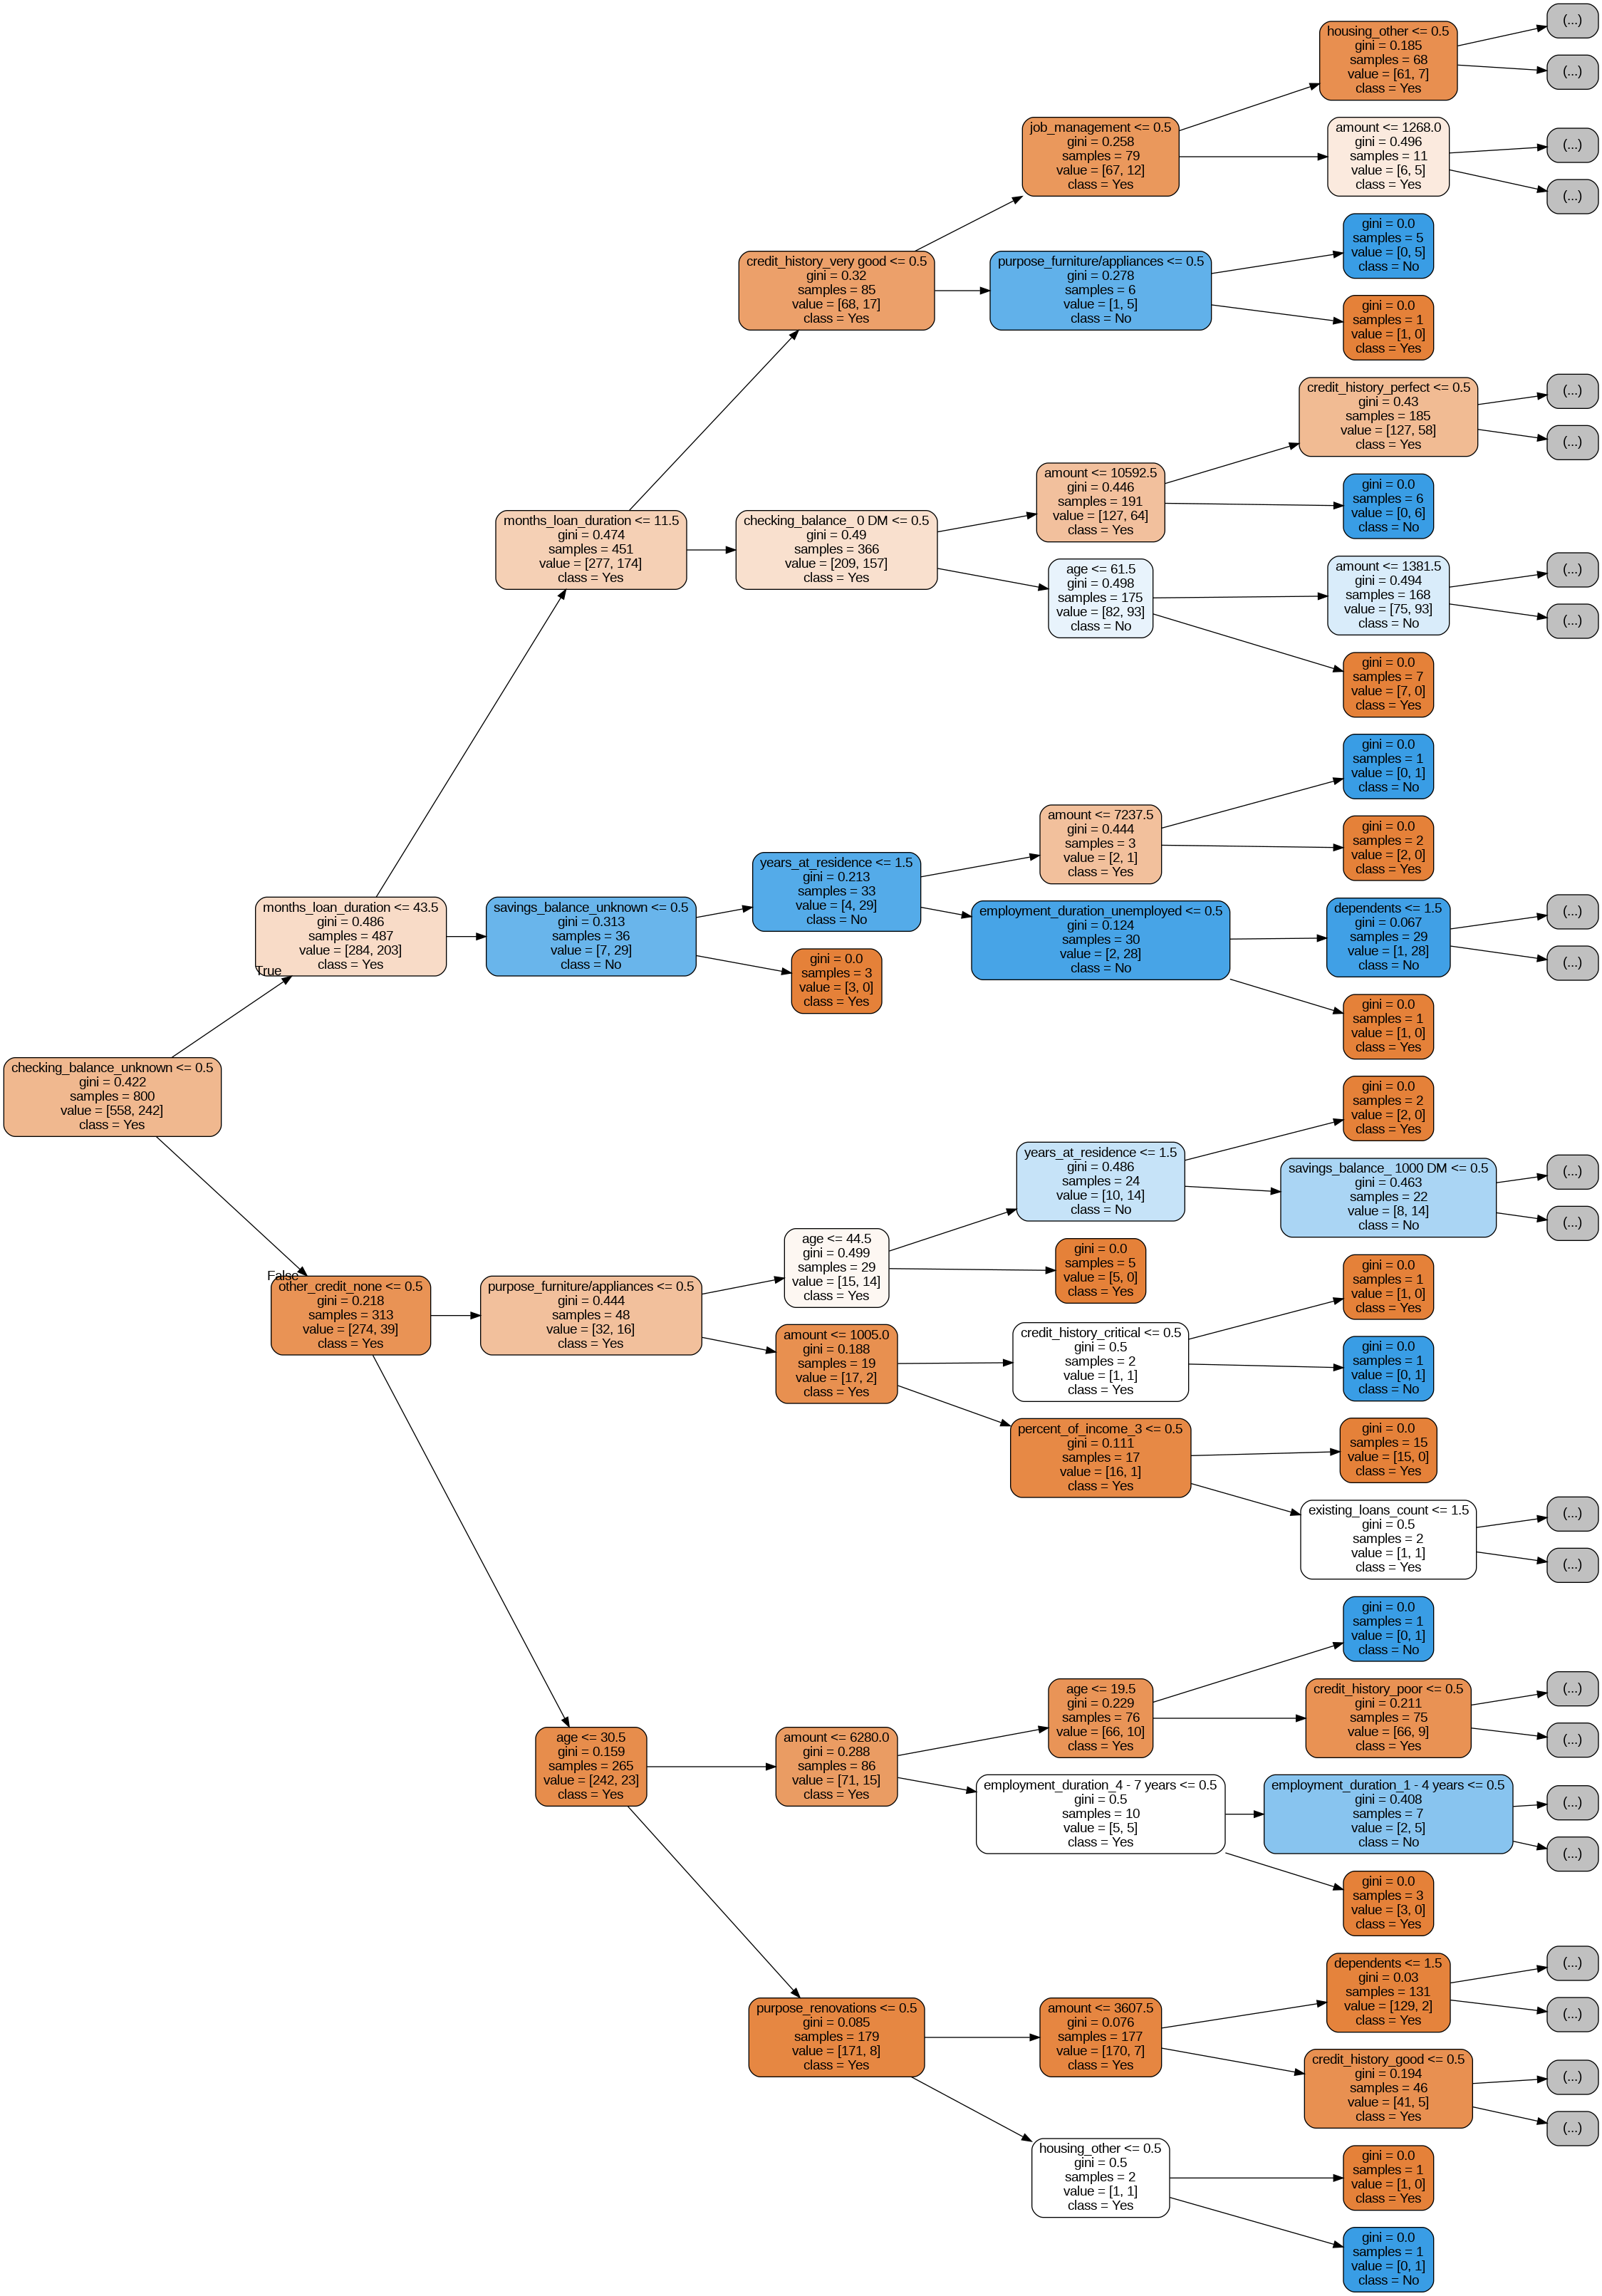

In [ ]:
# Exportar el modelo a archivo .dot
with open(r"tree.dot", 'w') as f:
     f = tree.export_graphviz(Arbol,
                              out_file=f,
                              max_depth=5,
                              rotate=True,
                              impurity = True,
                              feature_names = list(credit_2.drop(['default'], axis ='columns')),
                              class_names = ['Yes', 'No'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree.png'])
PImage("tree.png")

---
## Random Forest
---

---
### Random Search
---

In [ ]:
param_dist_forest = {"n_estimators": np.arange(1, 10, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "random_state": np.arange(10, 30, 1),
              "bootstrap": [True, False],
              "max_depth": np.arange(1, 20, 1),}
rnd_forest_clas = RandomForestClassifier()

rnd_forest = RandomizedSearchCV(estimator = rnd_forest_clas, param_distributions = param_dist_forest, n_iter = 100,
                                cv = 5, random_state=0, n_jobs = -1, scoring ='f1')

rnd_forest.fit( X = x_train, y = y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'random_state': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
                   random_state=0, scoring='f1')

---
### Grid Search
---

In [ ]:
param_dist_forest_2 = {"n_estimators": np.arange(5, 9, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "random_state": np.arange(23, 27, 1),
              "max_depth": np.arange(17, 21, 1),}

rnd_forest_clas_2 = RandomForestClassifier()

grid_forest = GridSearchCV(estimator = rnd_forest_clas_2, param_grid = param_dist_forest_2, cv = 5, scoring ='f1')

grid_forest.fit( X = x_train, y = y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([17, 18, 19, 20]),
                         'n_estimators': array([5, 6, 7, 8]),
                         'random_state': array([23, 24, 25, 26])},
             scoring='f1')

---
### Creacion del Modelo
---

In [ ]:
Random_Forest_rnd = rnd_forest.best_estimator_
Random_Forest_rnd.fit( X = x_train, y = y_train)

RandomForestClassifier(criterion='log_loss', max_depth=19, n_estimators=7,
                       random_state=25)

In [ ]:
Random_Forest_grid = grid_forest.best_estimator_
Random_Forest_grid.fit( X = x_train, y = y_train)

RandomForestClassifier(criterion='entropy', max_depth=18, n_estimators=7,
                       random_state=25)

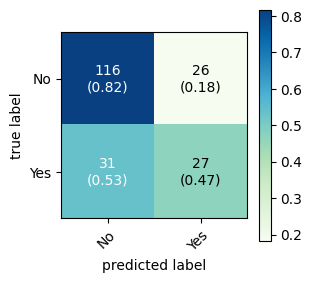

In [ ]:
predictions_forest_rnd = Random_Forest_rnd.predict(X=x_test)
score_forest_rnd = Random_Forest_rnd.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_forest_rnd),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, Random_Forest_rnd.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.79      0.82      0.80       142
         yes       0.51      0.47      0.49        58

    accuracy                           0.71       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.71      0.71      0.71       200



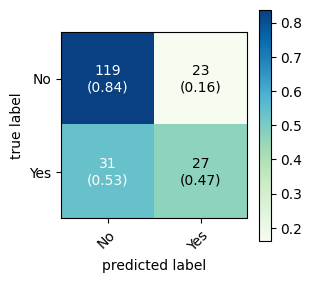

In [ ]:
predictions_forest_Grid = Random_Forest_grid.predict(X=x_test)
score_forest_Grid = Random_Forest_grid.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_forest_Grid),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, Random_Forest_grid.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.79      0.84      0.82       142
         yes       0.54      0.47      0.50        58

    accuracy                           0.73       200
   macro avg       0.67      0.65      0.66       200
weighted avg       0.72      0.73      0.72       200



---
## XGBoost
---

---
### Validation Set
---

In [ ]:
X_train, x_val, Y_train, y_val = train_test_split(x_train,
                                                    y_train, test_size=0.1, random_state=0)

---
### Random Search
---

In [ ]:
param_dist_XGB = {"max_depth": np.arange(1, 20, 1),
              "gamma": np.arange(0, 20, 1),
              "max_delta_step": np.arange(0, 20, 1),
              "eta": np.arange(0, 1, 0.1),
              }
rnd_XGB_class = xgb.XGBClassifier()

rnd_XGB = RandomizedSearchCV(estimator = rnd_XGB_class, param_distributions = param_dist_XGB, n_iter = 100,
                                cv = 5, random_state=0, n_jobs = -1, scoring ='f1')

rnd_XGB.fit( X = X_train, y = Y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'eta': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
                                        'max_delta_step': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
                   random_state=0, scoring='f1')

In [ ]:
rnd_XGB.best_params_

{'max_depth': 3, 'max_delta_step': 9, 'gamma': 1, 'eta': 0.8}

---
### Grid Search
---

In [ ]:
param_dist_XGB_2 = {"max_depth": np.arange(1, 5, 1),
              "gamma": np.arange(0, 3, 1),
              "max_delta_step": np.arange(7, 11, 1),
              "eta": np.arange(0.8, 0.9, 0.01),
              }
rnd_XGB_class_2 = xgb.XGBClassifier()

grid_XGB = GridSearchCV(estimator = rnd_XGB_class_2, param_grid = param_dist_XGB_2, cv = 5, scoring ='f1')

grid_XGB.fit( X = X_train, y = Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89]),
                         'gamma': array([0, 1, 2]),
                         'max_delta_step': array([ 7,  8,  9, 10]),
                         'max_depth': array([1, 2, 3, 4])},
             scoring='f1')

In [ ]:
grid_XGB.best_params_

{'eta': 0.8700000000000001, 'gamma': 0, 'max_delta_step': 7, 'max_depth': 2}

---
### Creacion del Modelo
---

In [ ]:
evalset = [(X_train, Y_train), (x_val,y_val)]

In [ ]:
XBG_rnd = rnd_XGB.best_estimator_
XBG_rnd.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

In [ ]:
XBG_grid = grid_XGB.best_estimator_
XBG_grid.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

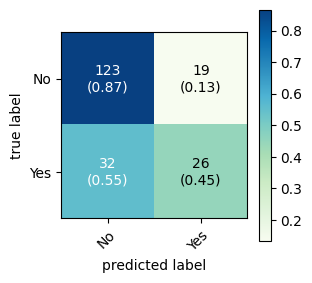

In [ ]:
predictions_XGBoost_rnd = XBG_rnd.predict(X=x_test)
score_XGBoost_rnd = XBG_rnd.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_rnd),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_rnd.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.79      0.87      0.83       142
         yes       0.58      0.45      0.50        58

    accuracy                           0.74       200
   macro avg       0.69      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



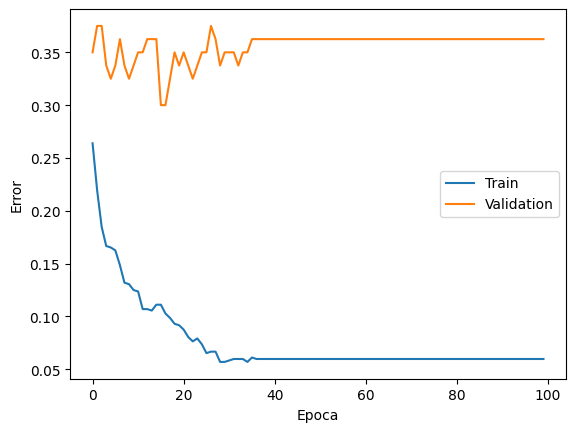

In [ ]:
results_rnd = XBG_rnd.evals_result()
plt.plot(results_rnd['validation_0']['error'], label='Train')
plt.plot(results_rnd['validation_1']['error'], label='Validation')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()
plt.show()

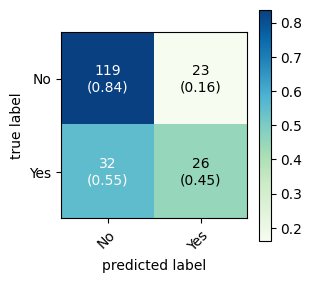

In [ ]:
predictions_XGBoost_grid = XBG_grid.predict(X=x_test)
score_XGBoost_grid = XBG_grid.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_grid),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_grid.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.79      0.84      0.81       142
         yes       0.53      0.45      0.49        58

    accuracy                           0.73       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.71      0.72      0.72       200



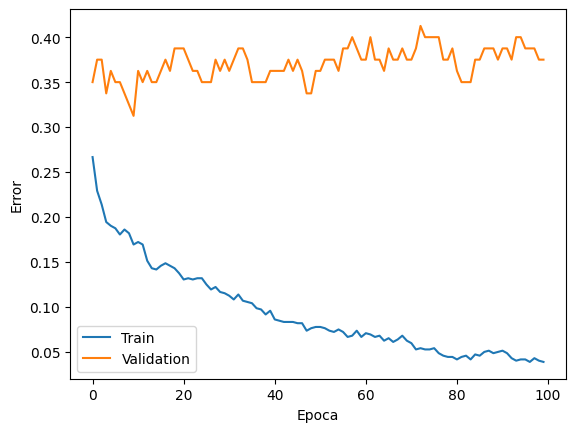

In [ ]:
results_grid = XBG_grid.evals_result()
plt.plot(results_grid['validation_0']['error'], label='Train')
plt.plot(results_grid['validation_1']['error'], label='Validation')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()
plt.show()

---
### Early Stopping
---

In [ ]:
param_dist_XGB_stopping = {"early_stopping_rounds":np.arange(1, 20, 1),
                    }

XGB_class_stopping = xgb.XGBClassifier(eta = 0.8700000000000001, gamma = 0, max_delta_step = 7, max_depth = 2)

XGB_Stopping_Grid = GridSearchCV(estimator = XGB_class_stopping, param_grid = param_dist_XGB_stopping,
                          cv = 5, scoring ='f1')

XGB_Stopping_Grid.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[0]	validation_0-error:0.26528	validation_1-error:0.33750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-error:0.25278	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-error:0.22083	validation_1-error:0.38750
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	validation_0-error:0.18750	validation_1-error:0.35000
[9]	validation_0-error:0.18611	validation_1-error:0.35000
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[0]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	vali

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[0]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validati

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	validation_0-error:0.18750	validation_1-error:0.35000
[9]	validation_0-error:0.18611	validation_1-error:0.35000
[10]	validation_0-error:0.17083	validation_1-error:0.33750
[11]	validation_0-error:0.17500	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.32500
[13]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[0]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	validation_0-error:0.18750	validation_1-error:0.35000
[9]	validation_0-error:0.18611	validation_1-error:0.35000
[10]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	valida

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750
[12]	validation_0-error:0.17083	validation_1-error:0.31250
[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.33750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	validation_0-error:0.18750	validation_1-error:0.35000
[9]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-error:0.17083	validation_1-error:0.31250
[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.33750
[31]	validation_0-error:0.13611	validation_1-error:0.33750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[0]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[9]	validation_0-error:0.18056	validation_1-error:0.38750
[10]	validation_0-error:0.19028	validation_1-error:0.42500
[11]	validation_0-error:0.17639	validation_1-error:0.40000
[12]	validation_0-error:0.17778	validation_1-error:0.38750
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validat

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-error:0.13750	validation_1-error:0.33750
[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23056	validation_1-error:0.42500
[3]	validation_0-error:0.21528	validation_1-error:0.35000
[4]	validation_0-error:0.20972	validation_1-error:0.38750
[5]	validation_0-error:0.19444	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.33750
[7]	validation_0-error:0.19861	validation_1-error:0.33750
[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.33750
[31]	validation_0-error:0.13611	validation_1-error:0.33750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22222	validation_1-error:0.36250
[3]	validation_0-error:0.20556	validation_1-error:0.33750
[4]	validation_0-error:0.20833	validation_1-error:0.32500
[5]	validation_0-error:0.19583	validation_1-error:0.31250
[6]	validation_0-error:0.19444	validation_1-error:0.28750
[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[0]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750
[12]	validation_0-error:0.17083	validation_1-error:0.31250
[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.33750
[31]	validation_0-error:0.13611	validation_1-error:0.33750
[32]	validation_0-error:0.13750	validation_1-error:0.35000
[0]	validation_0-error:0.26667	validation_1-error:0.3500

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-error:0.15694	validation_1-error:0.32500
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-error:0.14722	validation_1-error:0.37500
[18]	validation_0-error:0.13750	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[9]	validation_0-error:0.18056	validation_1-error:0.38750
[10]	validation_0-error:0.19028	validation_1-error:0.42500
[11]	validation_0-error:0.17639	validation_1-error:0.40000
[12]	validation_0-error:0.17778	validation_1-error:0.38750
[13]	validation_0-error:0.18194	validation_1-error:0.42500
[14]	validation_0-error:0.18056	validation_1-error:0.41250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750
[12]	validation_0-error:0.17083	validation_1-error:0.31250
[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[27]	validation_0-error:0.13750	validation_1-error:0.32500
[28]	validation_0-error:0.12917	validation_1-error:0.28750
[29]	validation_0-error:0.12500	validation_1-error:0.28750
[30]	validation_0-error:0.12500	validation_1-error:0.26250
[31]	validation_0-error:0.13056	validation_1-error:0.26250
[32]	validation_0-error:0.12778	validation_1-error:0.28750
[33]	validation_0-error:0.12083	validation_1-error:0.28750
[34]	validation_0-error:0.12222	validation_1-error:0.262

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.350

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-error:0.15417	validation_1-error:0.33750
[20]	validation_0-error:0.15694	validation_1-error:0.32500
[21]	validation_0-error:0.15556	validation_1-error:0.30000
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500
[11]	validation_0-error:0.17222	validation_1-error:0.36250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	validation_0-error:0.14722	validation_1-error:0.37500
[18]	validation_0-error:0.13750	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[9]	validation_0-error:0.18056	validation_1-error:0.38750
[10]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750
[12]	validation_0-error:0.17083	validation_1-error:0.31250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[27]	validation_0-error:0.13750	validation_1-error:0.32500
[28]	validation_0-error:0.12917	validation_1-error:0.28750
[29]	validation_0-error:0.12500	validation_1-error:0.287

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.337

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-error:0.15556	validation_1-error:0.30000
[18]	validation_0-error:0.15694	validation_1-error:0.33750
[19]	validation_0-error:0.15417	validation_1-error:0.33750
[20]	validation_0-error:0.15694	validation_1-error:0.32500
[21]	validation_0-error:0.15556	validation_1-error:0.30000
[22]	validation_0-error:0.15972	validation_1-error:0.28750
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]	validation_0-error:0.19583	validation_1-error:0.31250
[7]	validation_0-error:0.19028	validation_1-error:0.31250
[8]	validation_0-error:0.19306	validation_1-error:0.32500
[9]	validation_0-error:0.18750	validation_1-error:0.35000
[10]	validation_0-error:0.17500	validation_1-error:0.37500


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.17222	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.37500
[13]	validation_0-error:0.16389	validation_1-error:0.36250
[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	validation_0-error:0.14722	validation_1-error:0.37500
[18]	validation_0-error:0.13750	validation_1-error:0.37500
[19]	validation_0-error:0.14028	validation_1-error:0.38750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.17639	validation_1-error:0.40000
[12]	validation_0-error:0.17778	validation_1-error:0.38750
[13]	validation_0-error:0.18194	validation_1-error:0.42500
[14]	validation_0-error:0.18056	validation_1-error:0.41250
[15]	validation_0-error:0.16806	validation_1-error:0.40000
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750
[12]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[27]	validation_0-error:0.13750	validation_1-error:0.32500
[28]	validation_0-error:0.12917	validation_1-error:0.28750
[29]	validation_0-error:0.12500	validation_1-error:0.28750
[30]	validation_0-error:0.12500	validation_1-error:0.26250
[31]	validation_0-error:0.13056	validation_1-error:0.262

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.33750
[31]	validation_0-error:0.13611	validation_1-error:0.337

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-error:0.18472	validation_1-error:0.28750
[8]	validation_0-error:0.18750	validation_1-error:0.35000
[9]	validation_0-error:0.18611	validation_1-error:0.35000
[10]	validation_0-error:0.17083	validation_1-error:0.33750
[11]	validation_0-error:0.17500	validation_1-error:0.36250
[12]	validation_0-error:0.16806	validation_1-error:0.32500
[13]	validation_0-error:0.16806	validation_1-error:0.33750
[14]	validation_0-error:0.16528	validation_1-error:0.32500
[15]	validation_0-error:0.16250	validation_1-error:0.32500
[16]	validation_0-error:0.15972	validation_1-error:0.32500
[17]	validation_0-error:0.15556	validation_1-error:0.30000
[18]	validation_0-error:0.15694	validation_1-error:0.33750
[19]	validation_0-error:0.15417	validation_1-error:0.33750
[20]	validation_0-error:0.15694	validation_1-error:0.32500
[21]	validation_0-error:0.15556	validation_1-error:0.30000
[22]	validation_0-error:0.15972	validation_1-error:0.28750
[23]	validation_0-error:0.14861	validation_1-error:0.30000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	validation_0-error:0.14722	validation_1-error:0.37500
[18]	validation_0-error:0.13750	validation_1-error:0.37500
[19]	validation_0-error:0.14028	validation_1-error:0.38750
[20]	validation_0-error:0.13750	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[9]	validation_0-error:0.18056	validation_1-error:0.38750
[10]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-error:0.16806	validation_1-error:0.36250
[17]	validation_0-error:0.16250	validation_1-error:0.37500
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	validation_0-error:0.17361	validation_1-error:0.35000
[11]	validation_0-error:0.17917	validation_1-error:0.33750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-error:0.17083	validation_1-error:0.31250
[13]	validation_0-error:0.17361	validation_1-error:0.31250
[14]	validation_0-error:0.16111	validation_1-error:0.30000
[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[27]	validation_0-error:0.13750	validation_1-error:0.32500
[28]	validation_0-error:0.12917	validation_1-error:0.287

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.30000
[26]	validation_0-error:0.15972	validation_1-error:0.30000
[27]	validation_0-error:0.15417	validation_1-error:0.32500
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15694	validation_1-error:0.35000
[30]	validation_0-error:0.13750	validation_1-error:0.337

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.16806	validation_1-error:0.33750
[14]	validation_0-error:0.16528	validation_1-error:0.32500
[15]	validation_0-error:0.16250	validation_1-error:0.32500
[16]	validation_0-error:0.15972	validation_1-error:0.32500
[17]	validation_0-error:0.15556	validation_1-error:0.30000
[18]	validation_0-error:0.15694	validation_1-error:0.33750
[19]	validation_0-error:0.15417	validation_1-error:0.33750
[20]	validation_0-error:0.15694	validation_1-error:0.32500
[21]	validation_0-error:0.15556	validation_1-error:0.30000
[22]	validation_0-error:0.15972	validation_1-error:0.28750
[23]	validation_0-error:0.14861	validation_1-error:0.30000
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5]	validation_0-error:0.20417	validation_1-error:0.31250
[6]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-error:0.15833	validation_1-error:0.37500
[15]	validation_0-error:0.16389	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	validation_0-error:0.14722	validation_1-error:0.37500
[18]	validation_0-error:0.13750	validation_1-error:0.37500
[19]	validation_0-error:0.14028	validation_1-error:0.38750
[20]	validation_0-error:0.13750	validation_1-error:0.37500
[21]	validation_0-error:0.13333	validation_1-error:0.38750
[22]	validation_0-error:0.12917	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.17639	validation_1-error:0.40000
[12]	validation_0-error:0.17778	validation_1-error:0.38750
[13]	validation_0-error:0.18194	validation_1-error:0.42500
[14]	validation_0-error:0.18056	validation_1-error:0.41250
[15]	validation_0-error:0.16806	validation_1-error:0.40000
[16]	validation_0-error:0.16806	validation_1-error:0.36250
[17]	validation_0-error:0.16250	validation_1-error:0.37500
[0]	validation_0-error:0.25417	validation_1-error:0.33750
[1]	validation_0-error:0.23750	validation_1-error:0.32500
[2]	validation_0-error:0.22639	validation_1-error:0.35000
[3]	validation_0-error:0.21944	validation_1-error:0.35000
[4]	validation_0-error:0.21528	validation_1-error:0.35000
[5]	validation_0-error:0.20972	validation_1-error:0.35000
[6]	validation_0-error:0.20694	validation_1-error:0.37500
[7]	validation_0-error:0.20139	validation_1-error:0.38750
[8]	validation_0-error:0.18889	validation_1-error:0.38750
[9]	validation_0-error:0.18333	validation_1-error:0.32500
[10]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.16389	validation_1-error:0.31250
[16]	validation_0-error:0.16389	validation_1-error:0.31250
[17]	validation_0-error:0.16111	validation_1-error:0.32500
[18]	validation_0-error:0.15694	validation_1-error:0.35000
[19]	validation_0-error:0.15139	validation_1-error:0.32500
[20]	validation_0-error:0.14722	validation_1-error:0.35000
[21]	validation_0-error:0.14028	validation_1-error:0.32500
[22]	validation_0-error:0.13889	validation_1-error:0.35000
[23]	validation_0-error:0.14167	validation_1-error:0.36250
[24]	validation_0-error:0.13472	validation_1-error:0.35000
[25]	validation_0-error:0.14167	validation_1-error:0.33750
[26]	validation_0-error:0.13750	validation_1-error:0.33750
[27]	validation_0-error:0.13750	validation_1-error:0.32500
[28]	validation_0-error:0.12917	validation_1-error:0.28750
[29]	validation_0-error:0.12500	validation_1-error:0.28750
[30]	validation_0-error:0.12500	validation_1-error:0.26250
[31]	validation_0-error:0.13056	validation_1-error:0.262

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.19861	validation_1-error:0.33750
[9]	validation_0-error:0.19722	validation_1-error:0.35000
[10]	validation_0-error:0.18889	validation_1-error:0.33750
[11]	validation_0-error:0.19028	validation_1-error:0.31250
[12]	validation_0-error:0.19028	validation_1-error:0.32500
[13]	validation_0-error:0.18611	validation_1-error:0.33750
[14]	validation_0-error:0.18889	validation_1-error:0.33750
[15]	validation_0-error:0.17778	validation_1-error:0.36250
[16]	validation_0-error:0.17361	validation_1-error:0.36250
[17]	validation_0-error:0.17361	validation_1-error:0.33750
[18]	validation_0-error:0.16944	validation_1-error:0.33750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16944	validation_1-error:0.31250
[21]	validation_0-error:0.16111	validation_1-error:0.31250
[22]	validation_0-error:0.16667	validation_1-error:0.33750
[23]	validation_0-error:0.16111	validation_1-error:0.33750
[24]	validation_0-error:0.16667	validation_1-error:0.30000

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-error:0.16528	validation_1-error:0.32500
[15]	validation_0-error:0.16250	validation_1-error:0.32500
[16]	validation_0-error:0.15972	validation_1-error:0.32500
[17]	validation_0-error:0.15556	validation_1-error:0.30000
[18]	validation_0-error:0.15694	validation_1-error:0.33750
[19]	validation_0-error:0.15417	validation_1-error:0.33750
[20]	validation_0-error:0.15694	validation_1-error:0.32500
[21]	validation_0-error:0.15556	validation_1-error:0.30000
[22]	validation_0-error:0.15972	validation_1-error:0.28750
[23]	validation_0-error:0.14861	validation_1-error:0.30000
[24]	validation_0-error:0.14722	validation_1-error:0.31250
[25]	validation_0-error:0.14722	validation_1-error:0.28750
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.25278	validation_1-error:0.37500
[2]	validation_0-error:0.24861	validation_1-error:0.35000
[3]	validation_0-error:0.22917	validation_1-error:0.32500
[4]	validation_0-error:0.21667	validation_1-error:0.31250
[5

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-error:0.14028	validation_1-error:0.38750
[20]	validation_0-error:0.13750	validation_1-error:0.37500
[21]	validation_0-error:0.13333	validation_1-error:0.38750
[22]	validation_0-error:0.12917	validation_1-error:0.37500
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.23333	validation_1-error:0.41250
[2]	validation_0-error:0.22500	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.38750
[4]	validation_0-error:0.20972	validation_1-error:0.37500
[5]	validation_0-error:0.20000	validation_1-error:0.37500
[6]	validation_0-error:0.19306	validation_1-error:0.35000
[7]	validation_0-error:0.19028	validation_1-error:0.35000
[8]	validation_0-error:0.18056	validation_1-error:0.37500
[9]	validation_0-error:0.18056	validation_1-error:0.38750
[10]	validation_0-error:0.19028	validation_1-error:0.42500
[11]	validation_0-error:0.17639	validation_1-error:0.40000
[12]	validation_0-error:0.17778	validation_1-error:0.38750
[13]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-error:0.16250	validation_1-error:0.37500
[18]	validation_0-error:0.16250	validation_1-error:0.38750
[19]	validation_0-error:0.16250	validation_1-error:0.38750
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.21389	validation_1-error:0.37500
[3]	validation_0-error:0.19444	validation_1-error:0.33750
[4]	validation_0-error:0.19028	validation_1-error:0.36250
[5]	validation_0-error:0.18750	validation_1-error:0.35000
[6]	validation_0-error:0.18056	validation_1-error:0.35000
[7]	validation_0-error:0.18611	validation_1-error:0.33750
[8]	validation_0-error:0.18194	validation_1-error:0.32500
[9]	validation_0-error:0.16944	validation_1-error:0.31250
[10]	validation_0-error:0.17222	validation_1-error:0.36250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.16944	validation_1-error:0.35000
[12]	validation_0-error:0.15139	validation_1-error:0.36250
[13]	validation_0-error:0.14306	validation_1-error:0.35000
[14]	validation_0-error:0.14167	validation_1-error:0.35000
[15]	validation_0-error:0.14583	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	validation_0-error:0.14583	validation_1-error:0.36250
[18]	validation_0-error:0.14306	validation_1-error:0.38750
[19]	validation_0-error:0.13750	validation_1-error:0.38750
[20]	validation_0-error:0.13056	validation_1-error:0.38750
[21]	validation_0-error:0.13194	validation_1-error:0.37500
[22]	validation_0-error:0.13056	validation_1-error:0.36250
[23]	validation_0-error:0.13194	validation_1-error:0.36250


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eta=0.8700000000000001, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=7,
                                     max_depth=2, max_leaves=None,
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'early_stopping_rounds': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='f1')

In [ ]:
XGB_Stopping_Grid.best_params_

{'early_stopping_rounds': 14}

In [ ]:
XBG_Stopping = XGB_Stopping_Grid.best_estimator_
XBG_Stopping.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.21389	validation_1-error:0.37500
[3]	validation_0-error:0.19444	validation_1-error:0.33750
[4]	validation_0-error:0.19028	validation_1-error:0.36250
[5]	validation_0-error:0.18750	validation_1-error:0.35000
[6]	validation_0-error:0.18056	validation_1-error:0.35000
[7]	validation_0-error:0.18611	validation_1-error:0.33750
[8]	validation_0-error:0.18194	validation_1-error:0.32500
[9]	validation_0-error:0.16944	validation_1-error:0.31250
[10]	validation_0-error:0.17222	validation_1-error:0.36250
[11]	validation_0-error:0.16944	validation_1-error:0.35000
[12]	validation_0-error:0.15139	validation_1-error:0.36250
[13]	validation_0-error:0.14306	validation_1-error:0.35000
[14]	validation_0-error:0.14167	validation_1-error:0.35000
[15]	validation_0-error:0.14583	validation_1-error:0.36250
[16]	validation_0-error:0.14861	validation_1-error:0.37500
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=14,
              enable_categorical=False, eta=0.8700000000000001,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=7,
              max_depth=2, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

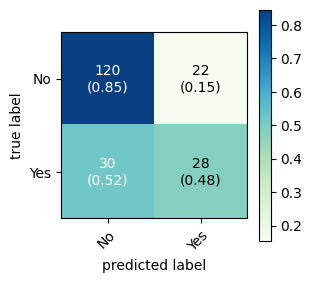

In [ ]:
predictions_XGBoost_Stopping = XBG_Stopping.predict(X=x_test)
score_forest_rnd = XBG_Stopping.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_Stopping),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_Stopping.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.80      0.85      0.82       142
         yes       0.56      0.48      0.52        58

    accuracy                           0.74       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.73      0.74      0.73       200



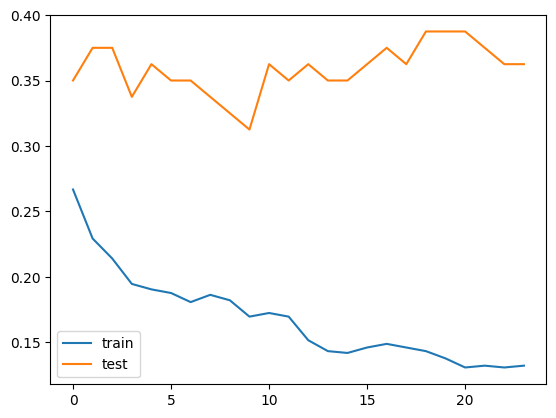

In [ ]:
results_2 = XBG_Stopping.evals_result()
plt.plot(results_2['validation_0']['error'], label='train')
plt.plot(results_2['validation_1']['error'], label='test')

plt.legend()

plt.show()

---
### Subsample
---

In [ ]:
param_dist_XGB_sample = {"subsample":np.arange(0, 1, 0.1),
                    }

XGB_class_sample = xgb.XGBClassifier(eta = 0.8700000000000001, gamma = 0, max_delta_step = 7, max_depth = 2,
                                    early_stopping_rounds=14)

grid_XGB_Sample = GridSearchCV(estimator = XGB_class_sample, param_grid = param_dist_XGB_sample, cv = 5,
                               scoring ='f1')

grid_XGB_Sample.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29306	validation_1-error:0.38750
[2]	validation_0-error:0.29306	validation_1-error:0.38750
[3]	validation_0-error:0.29306	validation_1-error:0.38750
[4]	validation_0-error:0.29306	validation_1-error:0.38750
[5]	validation_0-error:0.29306	validation_1-error:0.38750
[6]	validation_0-error:0.29306	validation_1-error:0.38750
[7]	validation_0-error:0.29306	validation_1-error:0.38750
[8]	validation_0-error:0.29306	validation_1-error:0.38750
[9]	validation_0-error:0.29306	validation_1-error:0.38750
[10]	validation_0-error:0.29306	validation_1-error:0.38750
[11]	validation_0-error:0.29306	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-error:0.29306	validation_1-error:0.38750
[13]	validation_0-error:0.29306	validation_1-error:0.38750
[14]	validation_0-error:0.29306	validation_1-error:0.38750
[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29306	validation_1-error:0.38750
[2]	validation_0-error:0.29306	validation_1-error:0.38750
[3]	validation_0-error:0.29306	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-error:0.29306	validation_1-error:0.38750
[5]	validation_0-error:0.29306	validation_1-error:0.38750
[6]	validation_0-error:0.29306	validation_1-error:0.38750
[7]	validation_0-error:0.29306	validation_1-error:0.38750
[8]	validation_0-error:0.29306	validation_1-error:0.38750
[9]	validation_0-error:0.29306	validation_1-error:0.38750
[10]	validation_0-error:0.29306	validation_1-error:0.38750
[11]	validation_0-error:0.29306	validation_1-error:0.38750
[12]	validation_0-error:0.29306	validation_1-error:0.38750
[13]	validation_0-error:0.29306	validation_1-error:0.38750
[14]	validation_0-error:0.29306	validation_1-error:0.38750
[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29306	validation_1-error:0.38750
[2]	validation_0-error:0.29306	validation_1-error:0.38750
[3]	validation_0-error:0.29306	validation_1-error:0.38750
[4]	validation_0-error:0.29306	validation_1-error:0.38750
[5]	validation_0-error:0.29306	validation_1-error:0.38750
[6]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29306	validation_1-error:0.38750
[2]	validation_0-error:0.29306	validation_1-error:0.38750
[3]	validation_0-error:0.29306	validation_1-error:0.38750
[4]	validation_0-error:0.29306	validation_1-error:0.38750
[5]	validation_0-error:0.29306	validation_1-error:0.38750
[6]	validation_0-error:0.29306	validation_1-error:0.38750
[7]	validation_0-error:0.29306	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.29306	validation_1-error:0.38750
[9]	validation_0-error:0.29306	validation_1-error:0.38750
[10]	validation_0-error:0.29306	validation_1-error:0.38750
[11]	validation_0-error:0.29306	validation_1-error:0.38750
[12]	validation_0-error:0.29306	validation_1-error:0.38750
[13]	validation_0-error:0.29306	validation_1-error:0.38750
[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29306	validation_1-error:0.38750
[2]	validation_0-error:0.29306	validation_1-error:0.38750
[3]	validation_0-error:0.29306	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-error:0.29306	validation_1-error:0.38750
[5]	validation_0-error:0.29306	validation_1-error:0.38750
[6]	validation_0-error:0.29306	validation_1-error:0.38750
[7]	validation_0-error:0.29306	validation_1-error:0.38750
[8]	validation_0-error:0.29306	validation_1-error:0.38750
[9]	validation_0-error:0.29306	validation_1-error:0.38750
[10]	validation_0-error:0.29306	validation_1-error:0.38750
[11]	validation_0-error:0.29306	validation_1-error:0.38750
[12]	validation_0-error:0.29306	validation_1-error:0.38750
[13]	validation_0-error:0.29306	validation_1-error:0.38750
[14]	validation_0-error:0.29306	validation_1-error:0.38750
[0]	validation_0-error:0.32222	validation_1-error:0.37500
[1]	validation_0-error:0.27917	validation_1-error:0.36250
[2]	validation_0-error:0.29306	validation_1-error:0.36250
[3]	validation_0-error:0.30000	validation_1-error:0.35000
[4]	validation_0-error:0.30694	validation_1-error:0.42500
[5]	validation_0-error:0.27917	validation_1-error:0.36250
[6]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-error:0.29306	validation_1-error:0.40000
[22]	validation_0-error:0.30694	validation_1-error:0.36250
[23]	validation_0-error:0.26667	validation_1-error:0.31250
[24]	validation_0-error:0.30000	validation_1-error:0.28750
[25]	validation_0-error:0.32361	validation_1-error:0.31250
[26]	validation_0-error:0.32639	validation_1-error:0.27500
[27]	validation_0-error:0.29444	validation_1-error:0.30000
[28]	validation_0-error:0.33333	validation_1-error:0.31250
[29]	validation_0-error:0.29722	validation_1-error:0.32500
[30]	validation_0-error:0.29028	validation_1-error:0.31250
[31]	validation_0-error:0.28194	validation_1-error:0.26250
[32]	validation_0-error:0.30972	validation_1-error:0.33750
[33]	validation_0-error:0.29861	validation_1-error:0.30000
[34]	validation_0-error:0.28750	validation_1-error:0.30000
[35]	validation_0-error:0.26389	validation_1-error:0.28750
[36]	validation_0-error:0.25278	validation_1-error:0.30000
[37]	validation_0-error:0.26389	validation_1-error:0.337

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.28056	validation_1-error:0.42500
[9]	validation_0-error:0.25000	validation_1-error:0.42500
[10]	validation_0-error:0.26667	validation_1-error:0.41250
[11]	validation_0-error:0.27083	validation_1-error:0.43750
[12]	validation_0-error:0.28472	validation_1-error:0.48750
[13]	validation_0-error:0.29861	validation_1-error:0.46250
[14]	validation_0-error:0.28194	validation_1-error:0.43750
[15]	validation_0-error:0.27222	validation_1-error:0.45000
[0]	validation_0-error:0.35972	validation_1-error:0.52500
[1]	validation_0-error:0.28472	validation_1-error:0.40000
[2]	validation_0-error:0.26389	validation_1-error:0.38750
[3]	validation_0-error:0.27361	validation_1-error:0.38750
[4]	validation_0-error:0.25694	validation_1-error:0.43750
[5]	validation_0-error:0.28889	validation_1-error:0.48750
[6]	validation_0-error:0.29306	validation_1-error:0.47500
[7]	validation_0-error:0.29028	validation_1-error:0.45000
[8]	validation_0-error:0.27917	validation_1-error:0.38750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-error:0.28889	validation_1-error:0.40000
[10]	validation_0-error:0.29444	validation_1-error:0.51250
[11]	validation_0-error:0.32083	validation_1-error:0.46250
[12]	validation_0-error:0.30972	validation_1-error:0.46250
[13]	validation_0-error:0.30417	validation_1-error:0.42500
[14]	validation_0-error:0.26944	validation_1-error:0.45000
[15]	validation_0-error:0.29167	validation_1-error:0.48750
[0]	validation_0-error:0.30556	validation_1-error:0.47500
[1]	validation_0-error:0.26528	validation_1-error:0.40000
[2]	validation_0-error:0.27083	validation_1-error:0.33750
[3]	validation_0-error:0.27222	validation_1-error:0.48750
[4]	validation_0-error:0.26667	validation_1-error:0.40000
[5]	validation_0-error:0.25694	validation_1-error:0.48750
[6]	validation_0-error:0.27917	validation_1-error:0.51250
[7]	validation_0-error:0.28472	validation_1-error:0.46250
[8]	validation_0-error:0.25278	validation_1-error:0.47500
[9]	validation_0-error:0.28889	validation_1-error:0.51250
[10]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.28472	validation_1-error:0.46250
[12]	validation_0-error:0.27083	validation_1-error:0.38750
[13]	validation_0-error:0.26806	validation_1-error:0.37500
[14]	validation_0-error:0.27778	validation_1-error:0.38750
[15]	validation_0-error:0.28333	validation_1-error:0.37500
[0]	validation_0-error:0.36250	validation_1-error:0.51250
[1]	validation_0-error:0.26250	validation_1-error:0.38750
[2]	validation_0-error:0.27361	validation_1-error:0.38750
[3]	validation_0-error:0.28611	validation_1-error:0.33750
[4]	validation_0-error:0.30417	validation_1-error:0.37500
[5]	validation_0-error:0.27917	validation_1-error:0.33750
[6]	validation_0-error:0.35833	validation_1-error:0.47500
[7]	validation_0-error:0.29722	validation_1-error:0.40000
[8]	validation_0-error:0.28194	validation_1-error:0.41250
[9]	validation_0-error:0.28194	validation_1-error:0.43750


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-error:0.28056	validation_1-error:0.37500
[11]	validation_0-error:0.26389	validation_1-error:0.47500
[12]	validation_0-error:0.26667	validation_1-error:0.46250
[13]	validation_0-error:0.25417	validation_1-error:0.41250
[14]	validation_0-error:0.26944	validation_1-error:0.43750
[15]	validation_0-error:0.27778	validation_1-error:0.35000
[16]	validation_0-error:0.28333	validation_1-error:0.40000
[17]	validation_0-error:0.26250	validation_1-error:0.42500
[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.29167	validation_1-error:0.42500
[2]	validation_0-error:0.28056	validation_1-error:0.42500
[3]	validation_0-error:0.26528	validation_1-error:0.41250
[4]	validation_0-error:0.26944	validation_1-error:0.46250
[5]	validation_0-error:0.27639	validation_1-error:0.45000
[6]	validation_0-error:0.28611	validation_1-error:0.43750
[7]	validation_0-error:0.26806	validation_1-error:0.38750
[8]	validation_0-error:0.27917	validation_1-error:0.42500
[9]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-error:0.24861	validation_1-error:0.37500
[22]	validation_0-error:0.23889	validation_1-error:0.41250
[23]	validation_0-error:0.22361	validation_1-error:0.42500
[24]	validation_0-error:0.24583	validation_1-error:0.45000
[25]	validation_0-error:0.23889	validation_1-error:0.36250
[26]	validation_0-error:0.23472	validation_1-error:0.33750
[27]	validation_0-error:0.21111	validation_1-error:0.38750
[28]	validation_0-error:0.24028	validation_1-error:0.41250
[29]	validation_0-error:0.23611	validation_1-error:0.40000
[30]	validation_0-error:0.22778	validation_1-error:0.37500
[31]	validation_0-error:0.22639	validation_1-error:0.35000
[32]	validation_0-error:0.20417	validation_1-error:0.37500
[33]	validation_0-error:0.22361	validation_1-error:0.43750
[34]	validation_0-error:0.22222	validation_1-error:0.40000
[35]	validation_0-error:0.22222	validation_1-error:0.42500
[36]	validation_0-error:0.21528	validation_1-error:0.42500
[37]	validation_0-error:0.21944	validation_1-error:0.437

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-error:0.24861	validation_1-error:0.40000
[13]	validation_0-error:0.24167	validation_1-error:0.43750
[14]	validation_0-error:0.25417	validation_1-error:0.36250
[15]	validation_0-error:0.26528	validation_1-error:0.36250
[16]	validation_0-error:0.24444	validation_1-error:0.37500
[17]	validation_0-error:0.29028	validation_1-error:0.42500
[18]	validation_0-error:0.26389	validation_1-error:0.38750
[19]	validation_0-error:0.27917	validation_1-error:0.37500
[0]	validation_0-error:0.27083	validation_1-error:0.32500
[1]	validation_0-error:0.26944	validation_1-error:0.28750
[2]	validation_0-error:0.25556	validation_1-error:0.30000
[3]	validation_0-error:0.24861	validation_1-error:0.28750
[4]	validation_0-error:0.29583	validation_1-error:0.38750
[5]	validation_0-error:0.24861	validation_1-error:0.33750
[6]	validation_0-error:0.25694	validation_1-error:0.31250
[7]	validation_0-error:0.26806	validation_1-error:0.35000
[8]	validation_0-error:0.24722	validation_1-error:0.40000
[9]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-error:0.24306	validation_1-error:0.31250
[11]	validation_0-error:0.24306	validation_1-error:0.33750
[12]	validation_0-error:0.23750	validation_1-error:0.37500
[13]	validation_0-error:0.24861	validation_1-error:0.33750
[14]	validation_0-error:0.24028	validation_1-error:0.33750
[15]	validation_0-error:0.23889	validation_1-error:0.32500
[0]	validation_0-error:0.31111	validation_1-error:0.36250
[1]	validation_0-error:0.30694	validation_1-error:0.35000
[2]	validation_0-error:0.28472	validation_1-error:0.33750
[3]	validation_0-error:0.26944	validation_1-error:0.38750
[4]	validation_0-error:0.28472	validation_1-error:0.43750
[5]	validation_0-error:0.26944	validation_1-error:0.36250
[6]	validation_0-error:0.29583	validation_1-error:0.45000
[7]	validation_0-error:0.27639	validation_1-error:0.37500
[8]	validation_0-error:0.26806	validation_1-error:0.40000
[9]	validation_0-error:0.27361	validation_1-error:0.46250
[10]	validation_0-error:0.25972	validation_1-error:0.42500
[11]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-error:0.23194	validation_1-error:0.32500
[17]	validation_0-error:0.24306	validation_1-error:0.32500
[18]	validation_0-error:0.25278	validation_1-error:0.38750
[19]	validation_0-error:0.26250	validation_1-error:0.40000
[20]	validation_0-error:0.26528	validation_1-error:0.40000
[21]	validation_0-error:0.26111	validation_1-error:0.42500
[22]	validation_0-error:0.26667	validation_1-error:0.40000
[23]	validation_0-error:0.24306	validation_1-error:0.46250
[24]	validation_0-error:0.24028	validation_1-error:0.41250
[25]	validation_0-error:0.24167	validation_1-error:0.37500
[26]	validation_0-error:0.26389	validation_1-error:0.35000
[27]	validation_0-error:0.23611	validation_1-error:0.41250
[28]	validation_0-error:0.25833	validation_1-error:0.40000
[29]	validation_0-error:0.23750	validation_1-error:0.38750
[30]	validation_0-error:0.26389	validation_1-error:0.41250
[0]	validation_0-error:0.34167	validation_1-error:0.45000
[1]	validation_0-error:0.31667	validation_1-error:0.38750

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.26528	validation_1-error:0.31250
[16]	validation_0-error:0.23889	validation_1-error:0.33750
[17]	validation_0-error:0.24167	validation_1-error:0.37500
[18]	validation_0-error:0.24722	validation_1-error:0.43750
[19]	validation_0-error:0.25972	validation_1-error:0.47500
[20]	validation_0-error:0.29722	validation_1-error:0.42500
[21]	validation_0-error:0.26111	validation_1-error:0.40000
[22]	validation_0-error:0.23750	validation_1-error:0.37500
[23]	validation_0-error:0.25000	validation_1-error:0.35000
[24]	validation_0-error:0.24861	validation_1-error:0.35000
[25]	validation_0-error:0.25278	validation_1-error:0.40000
[26]	validation_0-error:0.25417	validation_1-error:0.38750
[27]	validation_0-error:0.25694	validation_1-error:0.40000
[28]	validation_0-error:0.25556	validation_1-error:0.40000
[29]	validation_0-error:0.23750	validation_1-error:0.43750
[0]	validation_0-error:0.26806	validation_1-error:0.36250
[1]	validation_0-error:0.26111	validation_1-error:0.37500

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.21250	validation_1-error:0.42500
[14]	validation_0-error:0.20833	validation_1-error:0.41250
[15]	validation_0-error:0.20694	validation_1-error:0.45000
[16]	validation_0-error:0.20278	validation_1-error:0.42500
[17]	validation_0-error:0.19722	validation_1-error:0.37500
[18]	validation_0-error:0.20278	validation_1-error:0.28750
[19]	validation_0-error:0.21806	validation_1-error:0.31250
[20]	validation_0-error:0.19861	validation_1-error:0.31250
[21]	validation_0-error:0.18611	validation_1-error:0.36250
[22]	validation_0-error:0.20556	validation_1-error:0.35000
[23]	validation_0-error:0.19583	validation_1-error:0.41250
[24]	validation_0-error:0.18472	validation_1-error:0.37500
[25]	validation_0-error:0.20278	validation_1-error:0.38750
[26]	validation_0-error:0.19444	validation_1-error:0.40000
[27]	validation_0-error:0.20139	validation_1-error:0.35000
[28]	validation_0-error:0.20000	validation_1-error:0.40000
[29]	validation_0-error:0.20139	validation_1-error:0.362

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.23611	validation_1-error:0.36250
[14]	validation_0-error:0.24861	validation_1-error:0.41250
[15]	validation_0-error:0.23056	validation_1-error:0.33750
[16]	validation_0-error:0.23056	validation_1-error:0.32500
[17]	validation_0-error:0.21111	validation_1-error:0.37500
[18]	validation_0-error:0.22500	validation_1-error:0.32500
[19]	validation_0-error:0.23056	validation_1-error:0.35000
[20]	validation_0-error:0.22500	validation_1-error:0.36250
[21]	validation_0-error:0.22500	validation_1-error:0.33750
[22]	validation_0-error:0.21806	validation_1-error:0.35000
[23]	validation_0-error:0.22361	validation_1-error:0.38750
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.28750	validation_1-error:0.37500
[2]	validation_0-error:0.25972	validation_1-error:0.37500
[3]	validation_0-error:0.23611	validation_1-error:0.33750
[4]	validation_0-error:0.26111	validation_1-error:0.36250
[5]	validation_0-error:0.25139	validation_1-error:0.45000
[6]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.28472	validation_1-error:0.31250
[1]	validation_0-error:0.27778	validation_1-error:0.30000
[2]	validation_0-error:0.25833	validation_1-error:0.27500
[3]	validation_0-error:0.25000	validation_1-error:0.35000
[4]	validation_0-error:0.25556	validation_1-error:0.33750
[5]	validation_0-error:0.24167	validation_1-error:0.36250
[6]	validation_0-error:0.22500	validation_1-error:0.37500
[7]	validation_0-error:0.23194	validation_1-error:0.37500
[8]	validation_0-error:0.21667	validation_1-error:0.40000
[9]	validation_0-error:0.23472	validation_1-error:0.40000
[10]	validation_0-error:0.23056	validation_1-error:0.42500
[11]	validation_0-error:0.23333	validation_1-error:0.42500
[12]	validation_0-error:0.24306	validation_1-error:0.37500


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.23472	validation_1-error:0.41250
[14]	validation_0-error:0.23056	validation_1-error:0.37500
[15]	validation_0-error:0.23056	validation_1-error:0.38750
[0]	validation_0-error:0.30694	validation_1-error:0.50000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-error:0.25000	validation_1-error:0.45000
[2]	validation_0-error:0.24722	validation_1-error:0.42500
[3]	validation_0-error:0.24444	validation_1-error:0.43750
[4]	validation_0-error:0.24306	validation_1-error:0.43750
[5]	validation_0-error:0.25417	validation_1-error:0.40000
[6]	validation_0-error:0.25000	validation_1-error:0.37500
[7]	validation_0-error:0.24444	validation_1-error:0.36250
[8]	validation_0-error:0.24583	validation_1-error:0.38750
[9]	validation_0-error:0.23194	validation_1-error:0.40000
[10]	validation_0-error:0.24722	validation_1-error:0.42500
[11]	validation_0-error:0.22222	validation_1-error:0.42500
[12]	validation_0-error:0.21528	validation_1-error:0.41250
[13]	validation_0-error:0.23750	validation_1-error:0.38750
[14]	validation_0-error:0.23472	validation_1-error:0.43750
[15]	validation_0-error:0.22500	validation_1-error:0.47500
[16]	validation_0-error:0.22778	validation_1-error:0.43750
[17]	validation_0-error:0.23889	validation_1-error:0.41250
[18]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-error:0.22917	validation_1-error:0.33750
[4]	validation_0-error:0.23611	validation_1-error:0.31250
[5]	validation_0-error:0.24722	validation_1-error:0.30000
[6]	validation_0-error:0.23889	validation_1-error:0.33750
[7]	validation_0-error:0.22222	validation_1-error:0.28750
[8]	validation_0-error:0.22778	validation_1-error:0.33750
[9]	validation_0-error:0.21806	validation_1-error:0.32500
[10]	validation_0-error:0.21389	validation_1-error:0.36250
[11]	validation_0-error:0.20556	validation_1-error:0.35000
[12]	validation_0-error:0.21667	validation_1-error:0.35000
[13]	validation_0-error:0.20833	validation_1-error:0.32500
[14]	validation_0-error:0.20417	validation_1-error:0.33750
[15]	validation_0-error:0.20556	validation_1-error:0.32500
[16]	validation_0-error:0.19583	validation_1-error:0.32500
[17]	validation_0-error:0.20417	validation_1-error:0.30000
[18]	validation_0-error:0.18750	validation_1-error:0.28750
[19]	validation_0-error:0.20000	validation_1-error:0.31250
[20]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-error:0.24167	validation_1-error:0.36250
[9]	validation_0-error:0.24028	validation_1-error:0.33750
[10]	validation_0-error:0.21667	validation_1-error:0.38750
[11]	validation_0-error:0.23472	validation_1-error:0.35000
[12]	validation_0-error:0.23333	validation_1-error:0.37500
[13]	validation_0-error:0.23611	validation_1-error:0.32500
[14]	validation_0-error:0.23750	validation_1-error:0.31250
[15]	validation_0-error:0.23750	validation_1-error:0.35000
[16]	validation_0-error:0.23333	validation_1-error:0.35000
[17]	validation_0-error:0.25000	validation_1-error:0.36250
[18]	validation_0-error:0.22500	validation_1-error:0.33750
[19]	validation_0-error:0.22917	validation_1-error:0.35000
[20]	validation_0-error:0.21389	validation_1-error:0.31250
[21]	validation_0-error:0.20972	validation_1-error:0.31250
[22]	validation_0-error:0.21667	validation_1-error:0.30000
[23]	validation_0-error:0.21528	validation_1-error:0.36250
[24]	validation_0-error:0.21528	validation_1-error:0.30000

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-error:0.21389	validation_1-error:0.40000
[12]	validation_0-error:0.20833	validation_1-error:0.37500
[13]	validation_0-error:0.22222	validation_1-error:0.38750
[14]	validation_0-error:0.20278	validation_1-error:0.38750
[15]	validation_0-error:0.20278	validation_1-error:0.32500
[16]	validation_0-error:0.20417	validation_1-error:0.35000
[17]	validation_0-error:0.20694	validation_1-error:0.36250
[18]	validation_0-error:0.18889	validation_1-error:0.32500
[19]	validation_0-error:0.21389	validation_1-error:0.33750
[20]	validation_0-error:0.18611	validation_1-error:0.32500
[21]	validation_0-error:0.18333	validation_1-error:0.33750
[22]	validation_0-error:0.17778	validation_1-error:0.37500
[23]	validation_0-error:0.17917	validation_1-error:0.36250
[24]	validation_0-error:0.19444	validation_1-error:0.37500
[25]	validation_0-error:0.19167	validation_1-error:0.37500
[26]	validation_0-error:0.19028	validation_1-error:0.31250
[27]	validation_0-error:0.18333	validation_1-error:0.350

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.22778	validation_1-error:0.31250
[14]	validation_0-error:0.22639	validation_1-error:0.38750
[0]	validation_0-error:0.29861	validation_1-error:0.48750
[1]	validation_0-error:0.25833	validation_1-error:0.40000
[2]	validation_0-error:0.23472	validation_1-error:0.43750
[3]	validation_0-error:0.24028	validation_1-error:0.40000
[4]	validation_0-error:0.22361	validation_1-error:0.38750
[5]	validation_0-error:0.21944	validation_1-error:0.36250
[6]	validation_0-error:0.22778	validation_1-error:0.41250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-error:0.19722	validation_1-error:0.37500
[8]	validation_0-error:0.22361	validation_1-error:0.41250
[9]	validation_0-error:0.21806	validation_1-error:0.45000
[10]	validation_0-error:0.20833	validation_1-error:0.37500
[11]	validation_0-error:0.21944	validation_1-error:0.40000
[12]	validation_0-error:0.20972	validation_1-error:0.42500
[13]	validation_0-error:0.21667	validation_1-error:0.48750
[14]	validation_0-error:0.23194	validation_1-error:0.43750
[15]	validation_0-error:0.22222	validation_1-error:0.45000
[16]	validation_0-error:0.22917	validation_1-error:0.50000
[17]	validation_0-error:0.23056	validation_1-error:0.38750
[18]	validation_0-error:0.23056	validation_1-error:0.42500
[19]	validation_0-error:0.21389	validation_1-error:0.38750
[0]	validation_0-error:0.32639	validation_1-error:0.30000
[1]	validation_0-error:0.22361	validation_1-error:0.35000
[2]	validation_0-error:0.21806	validation_1-error:0.35000
[3]	validation_0-error:0.22083	validation_1-error:0.33750
[4]	

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.31389	validation_1-error:0.30000
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23194	validation_1-error:0.36250
[3]	validation_0-error:0.22500	validation_1-error:0.38750
[4]	validation_0-error:0.24028	validation_1-error:0.46250
[5]	validation_0-error:0.21806	validation_1-error:0.40000
[6]	validation_0-error:0.22778	validation_1-error:0.36250
[7]	validation_0-error:0.21944	validation_1-error:0.41250
[8]	validation_0-error:0.21944	validation_1-error:0.36250
[9]	validation_0-error:0.22500	validation_1-error:0.38750
[10]	validation_0-error:0.20417	validation_1-error:0.41250
[11]	validation_0-error:0.19444	validation_1-error:0.43750
[12]	validation_0-error:0.20556	validation_1-error:0.42500
[13]	validation_0-error:0.19306	validation_1-error:0.41250
[14]	validation_0-error:0.19861	validation_1-error:0.37500


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.29306	validation_1-error:0.38750
[1]	validation_0-error:0.27361	validation_1-error:0.35000
[2]	validation_0-error:0.26806	validation_1-error:0.41250
[3]	validation_0-error:0.22500	validation_1-error:0.35000
[4]	validation_0-error:0.24306	validation_1-error:0.38750
[5]	validation_0-error:0.23750	validation_1-error:0.38750
[6]	validation_0-error:0.23194	validation_1-error:0.36250
[7]	validation_0-error:0.24306	validation_1-error:0.38750
[8]	validation_0-error:0.22778	validation_1-error:0.36250
[9]	validation_0-error:0.21944	validation_1-error:0.37500
[10]	validation_0-error:0.21667	validation_1-error:0.36250
[11]	validation_0-error:0.20694	validation_1-error:0.36250
[12]	validation_0-error:0.20694	validation_1-error:0.40000
[13]	validation_0-error:0.19861	validation_1-error:0.37500
[14]	validation_0-error:0.20139	validation_1-error:0.37500


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.25000	validation_1-error:0.36250
[2]	validation_0-error:0.23194	validation_1-error:0.31250
[3]	validation_0-error:0.24861	validation_1-error:0.37500
[4]	validation_0-error:0.21389	validation_1-error:0.37500
[5]	validation_0-error:0.22917	validation_1-error:0.33750
[6]	validation_0-error:0.21806	validation_1-error:0.36250
[7]	validation_0-error:0.21111	validation_1-error:0.36250
[8]	validation_0-error:0.22361	validation_1-error:0.36250
[9]	validation_0-error:0.20833	validation_1-error:0.35000
[10]	validation_0-error:0.20556	validation_1-error:0.40000
[11]	validation_0-error:0.20000	validation_1-error:0.40000
[12]	validation_0-error:0.20417	validation_1-error:0.33750
[13]	validation_0-error:0.20139	validation_1-error:0.41250
[14]	validation_0-error:0.18472	validation_1-error:0.37500
[15]	validation_0-error:0.19722	validation_1-error:0.32500
[16]	validation_0-error:0.18056	validation_1-error:0.32500
[0]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-error:0.20694	validation_1-error:0.33750
[0]	validation_0-error:0.25833	validation_1-error:0.37500
[1]	validation_0-error:0.26250	validation_1-error:0.37500
[2]	validation_0-error:0.23333	validation_1-error:0.36250
[3]	validation_0-error:0.21111	validation_1-error:0.36250
[4]	validation_0-error:0.22083	validation_1-error:0.36250
[5]	validation_0-error:0.20000	validation_1-error:0.35000
[6]	validation_0-error:0.20972	validation_1-error:0.33750
[7]	validation_0-error:0.20694	validation_1-error:0.27500
[8]	validation_0-error:0.19722	validation_1-error:0.32500
[9]	validation_0-error:0.19444	validation_1-error:0.30000
[10]	validation_0-error:0.21528	validation_1-error:0.33750
[11]	validation_0-error:0.20694	validation_1-error:0.31250
[12]	validation_0-error:0.19167	validation_1-error:0.35000
[13]	validation_0-error:0.18750	validation_1-error:0.35000
[14]	validation_0-error:0.19167	validation_1-error:0.35000


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-error:0.16806	validation_1-error:0.36250
[16]	validation_0-error:0.17639	validation_1-error:0.38750
[17]	validation_0-error:0.17639	validation_1-error:0.36250
[18]	validation_0-error:0.16389	validation_1-error:0.36250
[19]	validation_0-error:0.18056	validation_1-error:0.32500
[20]	validation_0-error:0.16944	validation_1-error:0.35000
[0]	validation_0-error:0.31389	validation_1-error:0.30000
[1]	validation_0-error:0.25000	validation_1-error:0.38750
[2]	validation_0-error:0.23333	validation_1-error:0.35000
[3]	validation_0-error:0.25139	validation_1-error:0.37500
[4]	validation_0-error:0.24444	validation_1-error:0.41250
[5]	validation_0-error:0.23472	validation_1-error:0.41250
[6]	validation_0-error:0.23194	validation_1-error:0.36250
[7]	validation_0-error:0.22083	validation_1-error:0.35000
[8]	validation_0-error:0.20833	validation_1-error:0.35000
[9]	validation_0-error:0.22917	validation_1-error:0.37500
[10]	validation_0-error:0.19722	validation_1-error:0.45000
[11]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.24444	validation_1-error:0.35000
[2]	validation_0-error:0.22917	validation_1-error:0.33750
[3]	validation_0-error:0.22361	validation_1-error:0.32500
[4]	validation_0-error:0.23194	validation_1-error:0.33750
[5]	validation_0-error:0.22222	validation_1-error:0.36250
[6]	validation_0-error:0.20833	validation_1-error:0.32500
[7]	validation_0-error:0.20000	validation_1-error:0.30000
[8]	validation_0-error:0.20833	validation_1-error:0.32500
[9]	validation_0-error:0.20417	validation_1-error:0.31250
[10]	validation_0-error:0.20556	validation_1-error:0.32500
[11]	validation_0-error:0.20972	validation_1-error:0.31250
[12]	validation_0-error:0.18194	validation_1-error:0.31250
[13]	validation_0-error:0.19444	validation_1-error:0.30000
[14]	validation_0-error:0.18889	validation_1-error:0.30000
[15]	validation_0-error:0.17778	validation_1-error:0.30000
[16]	validation_0-error:0.18056	validation_1-error:0.28750
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-error:0.20833	validation_1-error:0.33750
[10]	validation_0-error:0.20278	validation_1-error:0.33750
[11]	validation_0-error:0.20833	validation_1-error:0.35000
[12]	validation_0-error:0.20278	validation_1-error:0.36250
[13]	validation_0-error:0.20000	validation_1-error:0.36250
[14]	validation_0-error:0.18750	validation_1-error:0.36250
[15]	validation_0-error:0.17639	validation_1-error:0.36250
[16]	validation_0-error:0.17917	validation_1-error:0.33750
[17]	validation_0-error:0.17778	validation_1-error:0.36250
[18]	validation_0-error:0.17917	validation_1-error:0.35000
[19]	validation_0-error:0.18333	validation_1-error:0.35000
[0]	validation_0-error:0.24444	validation_1-error:0.35000
[1]	validation_0-error:0.24722	validation_1-error:0.36250
[2]	validation_0-error:0.23194	validation_1-error:0.36250
[3]	validation_0-error:0.21667	validation_1-error:0.36250
[4]	validation_0-error:0.20556	validation_1-error:0.36250
[5]	validation_0-error:0.20694	validation_1-error:0.38750
[6]	

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-error:0.14861	validation_1-error:0.36250
[27]	validation_0-error:0.15000	validation_1-error:0.32500
[28]	validation_0-error:0.15556	validation_1-error:0.35000
[29]	validation_0-error:0.15833	validation_1-error:0.31250
[30]	validation_0-error:0.15417	validation_1-error:0.35000
[31]	validation_0-error:0.14722	validation_1-error:0.31250
[32]	validation_0-error:0.13889	validation_1-error:0.32500
[33]	validation_0-error:0.14583	validation_1-error:0.30000
[34]	validation_0-error:0.14167	validation_1-error:0.35000
[35]	validation_0-error:0.13750	validation_1-error:0.35000
[0]	validation_0-error:0.28333	validation_1-error:0.45000
[1]	validation_0-error:0.25694	validation_1-error:0.36250
[2]	validation_0-error:0.22639	validation_1-error:0.38750
[3]	validation_0-error:0.23333	validation_1-error:0.36250
[4]	validation_0-error:0.24583	validation_1-error:0.37500
[5]	validation_0-error:0.23750	validation_1-error:0.40000
[6]	validation_0-error:0.23750	validation_1-error:0.38750
[7]	

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-error:0.19444	validation_1-error:0.32500
[11]	validation_0-error:0.17361	validation_1-error:0.33750
[12]	validation_0-error:0.17222	validation_1-error:0.33750
[13]	validation_0-error:0.17500	validation_1-error:0.36250
[14]	validation_0-error:0.16528	validation_1-error:0.32500
[15]	validation_0-error:0.15694	validation_1-error:0.30000
[16]	validation_0-error:0.17083	validation_1-error:0.28750
[17]	validation_0-error:0.15278	validation_1-error:0.30000
[18]	validation_0-error:0.15139	validation_1-error:0.28750
[19]	validation_0-error:0.16944	validation_1-error:0.28750
[20]	validation_0-error:0.16528	validation_1-error:0.28750
[21]	validation_0-error:0.16528	validation_1-error:0.30000
[22]	validation_0-error:0.15694	validation_1-error:0.27500
[23]	validation_0-error:0.16667	validation_1-error:0.28750
[24]	validation_0-error:0.15972	validation_1-error:0.30000
[25]	validation_0-error:0.16250	validation_1-error:0.31250
[26]	validation_0-error:0.15694	validation_1-error:0.287

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.20278	validation_1-error:0.40000
[7]	validation_0-error:0.19028	validation_1-error:0.41250
[8]	validation_0-error:0.19028	validation_1-error:0.40000
[9]	validation_0-error:0.18889	validation_1-error:0.43750
[10]	validation_0-error:0.18056	validation_1-error:0.38750
[11]	validation_0-error:0.17778	validation_1-error:0.37500
[12]	validation_0-error:0.19583	validation_1-error:0.38750
[13]	validation_0-error:0.19306	validation_1-error:0.37500
[14]	validation_0-error:0.17639	validation_1-error:0.40000
[15]	validation_0-error:0.17639	validation_1-error:0.41250
[16]	validation_0-error:0.16806	validation_1-error:0.42500
[17]	validation_0-error:0.16806	validation_1-error:0.40000
[0]	validation_0-error:0.24444	validation_1-error:0.35000
[1]	validation_0-error:0.24028	validation_1-error:0.32500
[2]	validation_0-error:0.23194	validation_1-error:0.35000
[3]	validation_0-error:0.21250	validation_1-error:0.36250
[4]	validation_0-error:0.20278	validation_1-error:0.32500
[5]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.27222	validation_1-error:0.38750
[1]	validation_0-error:0.24028	validation_1-error:0.37500
[2]	validation_0-error:0.23472	validation_1-error:0.37500
[3]	validation_0-error:0.22778	validation_1-error:0.42500
[4]	validation_0-error:0.23194	validation_1-error:0.37500
[5]	validation_0-error:0.23611	validation_1-error:0.38750
[6]	validation_0-error:0.22500	validation_1-error:0.36250
[7]	validation_0-error:0.21528	validation_1-error:0.40000
[8]	validation_0-error:0.22500	validation_1-error:0.36250
[9]	validation_0-error:0.21250	validation_1-error:0.38750
[10]	validation_0-error:0.20833	validation_1-error:0.40000
[11]	validation_0-error:0.19583	validation_1-error:0.42500
[12]	validation_0-error:0.19306	validation_1-error:0.40000
[13]	validation_0-error:0.18472	validation_1-error:0.38750
[14]	validation_0-error:0.18611	validation_1-error:0.37500
[15]	validation_0-error:0.17222	validation_1-error:0.38750
[16]	validation_0-error:0.18056	validation_1-error:0.38750
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-error:0.16250	validation_1-error:0.31250
[27]	validation_0-error:0.15556	validation_1-error:0.30000
[28]	validation_0-error:0.16528	validation_1-error:0.30000
[29]	validation_0-error:0.16806	validation_1-error:0.31250
[30]	validation_0-error:0.15972	validation_1-error:0.28750
[31]	validation_0-error:0.15417	validation_1-error:0.30000
[32]	validation_0-error:0.15694	validation_1-error:0.32500
[33]	validation_0-error:0.15833	validation_1-error:0.30000
[34]	validation_0-error:0.15556	validation_1-error:0.32500
[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.26528	validation_1-error:0.33750
[2]	validation_0-error:0.25556	validation_1-error:0.32500
[3]	validation_0-error:0.24861	validation_1-error:0.33750
[4]	validation_0-error:0.23472	validation_1-error:0.35000
[5]	validation_0-error:0.21528	validation_1-error:0.35000
[6]	validation_0-error:0.19583	validation_1-error:0.33750
[7]	validation_0-error:0.18750	validation_1-error:0.32500
[8]	v

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-error:0.14583	validation_1-error:0.33750
[28]	validation_0-error:0.15972	validation_1-error:0.32500
[29]	validation_0-error:0.15278	validation_1-error:0.31250
[30]	validation_0-error:0.15833	validation_1-error:0.32500
[31]	validation_0-error:0.14861	validation_1-error:0.31250
[32]	validation_0-error:0.14444	validation_1-error:0.30000
[33]	validation_0-error:0.13750	validation_1-error:0.30000
[34]	validation_0-error:0.13750	validation_1-error:0.30000
[35]	validation_0-error:0.13611	validation_1-error:0.32500
[36]	validation_0-error:0.13472	validation_1-error:0.32500
[37]	validation_0-error:0.13056	validation_1-error:0.31250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.27222	validation_1-error:0.35000
[2]	validation_0-error:0.23750	validation_1-error:0.33750
[3]	validation_0-error:0.22917	validation_1-error:0.42500
[4]	validation_0-error:0.20833	validation_1-error:0.42500
[5]	validation_0-error:0.19861	validation_1-error:0.42500
[6]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-error:0.21944	validation_1-error:0.33750
[3]	validation_0-error:0.21528	validation_1-error:0.33750
[4]	validation_0-error:0.20556	validation_1-error:0.33750
[5]	validation_0-error:0.20694	validation_1-error:0.32500
[6]	validation_0-error:0.17778	validation_1-error:0.33750
[7]	validation_0-error:0.18472	validation_1-error:0.31250
[8]	validation_0-error:0.18194	validation_1-error:0.33750
[9]	validation_0-error:0.17778	validation_1-error:0.31250
[10]	validation_0-error:0.18472	validation_1-error:0.31250
[11]	validation_0-error:0.18194	validation_1-error:0.31250
[12]	validation_0-error:0.18472	validation_1-error:0.28750
[13]	validation_0-error:0.17500	validation_1-error:0.30000
[14]	validation_0-error:0.17361	validation_1-error:0.31250
[15]	validation_0-error:0.16806	validation_1-error:0.32500
[16]	validation_0-error:0.16944	validation_1-error:0.32500
[17]	validation_0-error:0.15833	validation_1-error:0.33750
[18]	validation_0-error:0.15972	validation_1-error:0.36250
[19]	

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-error:0.15972	validation_1-error:0.35000
[23]	validation_0-error:0.15556	validation_1-error:0.37500
[24]	validation_0-error:0.15417	validation_1-error:0.38750
[25]	validation_0-error:0.14722	validation_1-error:0.40000
[26]	validation_0-error:0.15000	validation_1-error:0.37500
[27]	validation_0-error:0.14028	validation_1-error:0.36250
[0]	validation_0-error:0.26667	validation_1-error:0.35000
[1]	validation_0-error:0.22917	validation_1-error:0.37500
[2]	validation_0-error:0.22083	validation_1-error:0.36250
[3]	validation_0-error:0.20417	validation_1-error:0.35000
[4]	validation_0-error:0.19861	validation_1-error:0.32500
[5]	validation_0-error:0.19444	validation_1-error:0.32500
[6]	validation_0-error:0.19028	validation_1-error:0.31250
[7]	validation_0-error:0.18750	validation_1-error:0.33750
[8]	validation_0-error:0.18472	validation_1-error:0.31250
[9]	validation_0-error:0.18611	validation_1-error:0.31250
[10]	validation_0-error:0.17917	validation_1-error:0.27500
[11]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.26528	validation_1-error:0.33750
[1]	validation_0-error:0.24722	validation_1-error:0.36250
[2]	validation_0-error:0.21806	validation_1-error:0.36250
[3]	validation_0-error:0.22083	validation_1-error:0.31250
[4]	validation_0-error:0.20000	validation_1-error:0.27500
[5]	validation_0-error:0.18333	validation_1-error:0.32500
[6]	validation_0-error:0.19444	validation_1-error:0.30000
[7]	validation_0-error:0.18472	validation_1-error:0.32500
[8]	validation_0-error:0.18750	validation_1-error:0.33750
[9]	validation_0-error:0.18056	validation_1-error:0.31250
[10]	validation_0-error:0.17222	validation_1-error:0.31250
[11]	validation_0-error:0.17222	validation_1-error:0.32500
[12]	validation_0-error:0.17500	validation_1-error:0.33750
[13]	validation_0-error:0.17361	validation_1-error:0.33750
[14]	validation_0-error:0.16806	validation_1-error:0.30000
[15]	validation_0-error:0.15833	validation_1-error:0.31250
[16]	validation_0-error:0.15000	validation_1-error:0.35000
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-error:0.22222	validation_1-error:0.28750
[8]	validation_0-error:0.22500	validation_1-error:0.31250
[9]	validation_0-error:0.22222	validation_1-error:0.31250
[10]	validation_0-error:0.22222	validation_1-error:0.26250
[11]	validation_0-error:0.22917	validation_1-error:0.33750
[12]	validation_0-error:0.21667	validation_1-error:0.35000
[13]	validation_0-error:0.22083	validation_1-error:0.36250
[14]	validation_0-error:0.19167	validation_1-error:0.33750
[15]	validation_0-error:0.18611	validation_1-error:0.37500
[16]	validation_0-error:0.18056	validation_1-error:0.37500
[17]	validation_0-error:0.18194	validation_1-error:0.38750
[18]	validation_0-error:0.17639	validation_1-error:0.37500
[19]	validation_0-error:0.17639	validation_1-error:0.36250
[20]	validation_0-error:0.17222	validation_1-error:0.33750
[21]	validation_0-error:0.17222	validation_1-error:0.32500
[22]	validation_0-error:0.16528	validation_1-error:0.36250
[23]	validation_0-error:0.17222	validation_1-error:0.35000


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=14,
                                     enable_categorical=False,
                                     eta=0.8700000000000001, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=7,
                                     max_depth=2, max_leaves=None,
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'subsample': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='f1')

In [ ]:
grid_XGB_Sample.best_params_

{'subsample': 0.4}

In [ ]:
XBG_Sample = grid_XGB_Sample.best_estimator_
XBG_Sample.fit( X = X_train, y = Y_train, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.30278	validation_1-error:0.31250
[1]	validation_0-error:0.25556	validation_1-error:0.35000
[2]	validation_0-error:0.22778	validation_1-error:0.35000
[3]	validation_0-error:0.22083	validation_1-error:0.31250
[4]	validation_0-error:0.20972	validation_1-error:0.33750
[5]	validation_0-error:0.20694	validation_1-error:0.38750
[6]	validation_0-error:0.21806	validation_1-error:0.33750
[7]	validation_0-error:0.22222	validation_1-error:0.28750
[8]	validation_0-error:0.22500	validation_1-error:0.31250
[9]	validation_0-error:0.22222	validation_1-error:0.31250
[10]	validation_0-error:0.22222	validation_1-error:0.26250
[11]	validation_0-error:0.22917	validation_1-error:0.33750
[12]	validation_0-error:0.21667	validation_1-error:0.35000
[13]	validation_0-error:0.22083	validation_1-error:0.36250
[14]	validation_0-error:0.19167	validation_1-error:0.33750
[15]	validation_0-error:0.18611	validation_1-error:0.37500
[16]	validation_0-error:0.18056	validation_1-error:0.37500
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=14,
              enable_categorical=False, eta=0.8700000000000001,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=7,
              max_depth=2, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

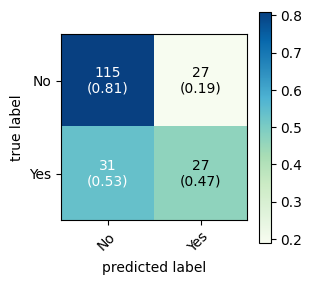

In [ ]:
predictions_XGBoost_Sample = XBG_Sample.predict(X=x_test)
score_forest_rnd = XBG_Sample.score(x_test, y_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_Sample),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_Sample.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.79      0.81      0.80       142
         yes       0.50      0.47      0.48        58

    accuracy                           0.71       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.70      0.71      0.71       200



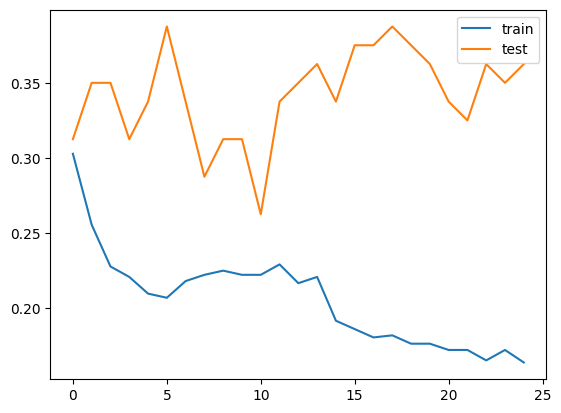

In [ ]:
results_2 = XBG_Sample.evals_result()
plt.plot(results_2['validation_0']['error'], label='train')
plt.plot(results_2['validation_1']['error'], label='test')

plt.legend()

plt.show()

---
## Red Neuronal (Perceptron Multicapa)
---

---
### Estandarizacion de Variables
---

---
#### Min - Max Scaler
---

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
#columns = ['months_loan_duration', 'amount', 'years_at_residence', 'age', 'existing_loans_count', 'dependents']
columns = X_train.columns
min_max_scaler.fit(X_train[columns])

############## ------------------- X_train ------------------- ##############

train_norm_min_max = min_max_scaler.transform(X_train[columns])
X_train_min_max = pd.DataFrame(train_norm_min_max)

############## ------------------- x_val ------------------- ##############

val_norm_min_max = min_max_scaler.transform(x_val[columns])
x_val_min_max = pd.DataFrame(val_norm_min_max)

############## ------------------- x_test ------------------- ##############

test_norm_min_max = min_max_scaler.transform(x_test[columns])
x_test_min_max = pd.DataFrame(test_norm_min_max)

In [ ]:
def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  hp_reg = hp.Choice('l2', values = [0.01, 0.02, 0.03])
  model.add(Dense(units = hp_units, activation = 'relu', kernel_regularizer = regularizers.l2(hp_reg),
                  input_shape = (len(X_train.columns),)))
  model.add(Dense(units = hp_units, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation="sigmoid"))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = "binary_crossentropy", metrics = ['binary_accuracy'])
  return model

---
##### Keras Tuner
---

In [ ]:
tuner_min_max = kt.Hyperband(model_builder,
                     objective = 'val_binary_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
tuner_min_max.search(X_train_min_max, Y_train, epochs = 10, validation_data = (x_val_min_max, y_val))

Trial 30 Complete [00h 00m 07s]
val_binary_accuracy: 0.625

Best val_binary_accuracy So Far: 0.699999988079071
Total elapsed time: 00h 01m 40s


In [ ]:
model_kt_min_max = tuner_min_max.get_best_models(num_models=1)[0]
model_kt_min_max.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               7680      
                                                                 
 dense_1 (Dense)             (None, 160)               25760     
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 34,241
Trainable params: 33,921
Non-trainable params: 320
_________________________________________________________________


In [ ]:
epo = 14
H_min_max = model_kt_min_max.fit(X_train_min_max,Y_train, epochs=epo,
                                 batch_size=128, validation_data=(x_val_min_max, y_val))

Epoch 1/14
6/6 [==============================] - 2s 77ms/step - loss: 1.2698 - binary_accuracy: 0.7153 - val_loss: 1.3732 - val_binary_accuracy: 0.7000
Epoch 2/14
6/6 [==============================] - 0s 21ms/step - loss: 1.2622 - binary_accuracy: 0.7194 - val_loss: 1.3694 - val_binary_accuracy: 0.7125
Epoch 3/14
6/6 [==============================] - 0s 18ms/step - loss: 1.2525 - binary_accuracy: 0.7278 - val_loss: 1.3660 - val_binary_accuracy: 0.7125
Epoch 4/14
6/6 [==============================] - 0s 16ms/step - loss: 1.2412 - binary_accuracy: 0.7347 - val_loss: 1.3623 - val_binary_accuracy: 0.7000
Epoch 5/14
6/6 [==============================] - 0s 19ms/step - loss: 1.2388 - binary_accuracy: 0.7417 - val_loss: 1.3589 - val_binary_accuracy: 0.6625
Epoch 6/14
6/6 [==============================] - 0s 19ms/step - loss: 1.2323 - binary_accuracy: 0.7361 - val_loss: 1.3552 - val_binary_accuracy: 0.6625
Epoch 7/14
6/6 [==============================] - 0s 16ms/step - loss: 1.2229 - bi

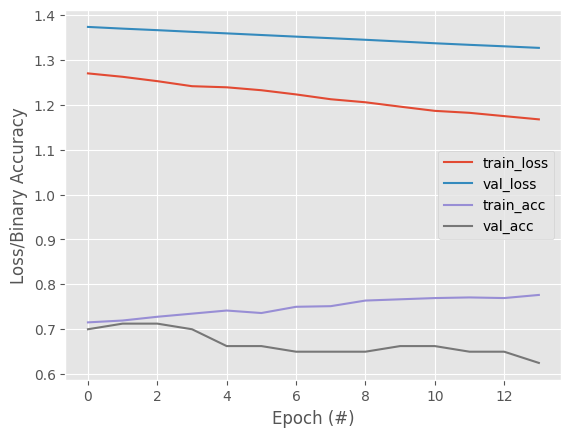

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epo), H_min_max.history["loss"], label="train_loss")
plt.plot(np.arange(0, epo), H_min_max.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epo), H_min_max.history["binary_accuracy"], label="train_acc")
plt.plot(np.arange(0, epo), H_min_max.history["val_binary_accuracy"], label="val_acc")
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch (#)")
plt.ylabel("Loss/Binary Accuracy")
plt.legend()

7/7 [==============================] - 0s 2ms/step


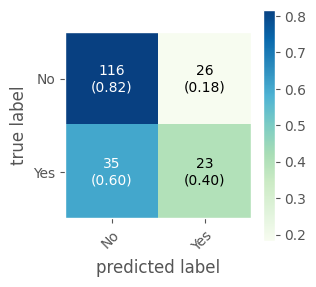

In [ ]:
predictions_rnn_min_max = model_kt_min_max.predict(x_test_min_max).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_rnn_min_max),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, predictions_rnn_min_max))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       142
           1       0.47      0.40      0.43        58

    accuracy                           0.69       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.68      0.69      0.69       200



In [ ]:
model_kt_min_max.evaluate(x_test_min_max, y_test)[1]

7/7 [==============================] - 0s 3ms/step - loss: 1.3095 - binary_accuracy: 0.6950


0.6949999928474426

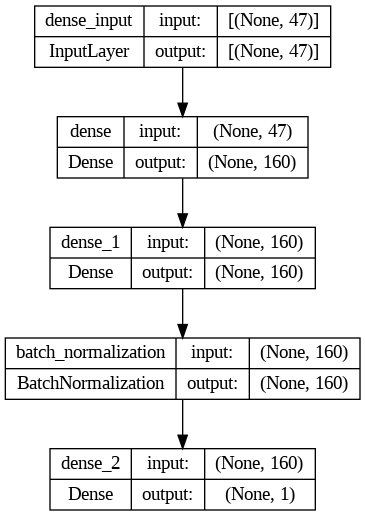

In [ ]:
from keras.utils import plot_model
plot_model(model_kt_min_max, 'net.png', show_shapes=True)

In [ ]:
BASE_FOLDER = "/content/drive/MyDrive/TFM Maicol Ardila/"
drive.mount('/content/drive')

model_kt_min_max.save(BASE_FOLDER+"MLP_Min_Max_Scaler.h5")

# Cargamos el modelo de drive
#from tensorflow.keras.models import load_model

#model_p = load_model(BASE_FOLDER+'deepCNN_KerasTunerF_CIFAR10.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
#### Standard Scaler
---

In [ ]:
standard_scaler = preprocessing.StandardScaler()

In [ ]:
columns = X_train.columns
standard_scaler.fit(X_train[columns])

############## ------------------- X_train ------------------- ##############

train_norm_standar = standard_scaler.transform(X_train[columns])
X_train_standar = pd.DataFrame(train_norm_standar)
X_train_standar.columns = X_train.columns
############## ------------------- x_val ------------------- ##############

val_norm_standar = standard_scaler.transform(x_val[columns])
x_val_standar = pd.DataFrame(val_norm_standar)

############## ------------------- x_test ------------------- ##############

test_norm_standar = standard_scaler.transform(x_test[columns])
x_test_standar= pd.DataFrame(test_norm_standar)

---
##### Keras Tuner
---

In [ ]:
tuner_standard = kt.Hyperband(model_builder,
                     objective = 'val_binary_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
tuner_standard.search(X_train_standar, Y_train, epochs = 10, validation_data = (x_val_standar, y_val))

Trial 26 Complete [00h 00m 04s]
val_binary_accuracy: 0.550000011920929

Best val_binary_accuracy So Far: 0.737500011920929
Total elapsed time: 00h 01m 36s


In [ ]:
model_kt_standard = tuner_standard.get_best_models(num_models=1)[0]
model_kt_standard.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               21504     
                                                                 
 dense_1 (Dense)             (None, 448)               201152    
                                                                 
 batch_normalization (BatchN  (None, 448)              1792      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1)                 449       
                                                                 
Total params: 224,897
Trainable params: 224,001
Non-trainable params: 896
_________________________________________________________________


In [ ]:
H_standar = model_kt_standard.fit(X_train_standar,Y_train, epochs=14, batch_size=128,
                                  validation_data=(x_val_standar, y_val))

Epoch 1/14
6/6 [==============================] - 1s 145ms/step - loss: 1.0647 - binary_accuracy: 0.9417 - val_loss: 1.4218 - val_binary_accuracy: 0.6875
Epoch 2/14
6/6 [==============================] - 0s 78ms/step - loss: 1.0613 - binary_accuracy: 0.9361 - val_loss: 1.4191 - val_binary_accuracy: 0.7000
Epoch 3/14
6/6 [==============================] - 0s 72ms/step - loss: 1.0496 - binary_accuracy: 0.9431 - val_loss: 1.4170 - val_binary_accuracy: 0.7000
Epoch 4/14
6/6 [==============================] - 0s 61ms/step - loss: 1.0375 - binary_accuracy: 0.9569 - val_loss: 1.4147 - val_binary_accuracy: 0.7125
Epoch 5/14
6/6 [==============================] - 0s 57ms/step - loss: 1.0323 - binary_accuracy: 0.9583 - val_loss: 1.4120 - val_binary_accuracy: 0.7125
Epoch 6/14
6/6 [==============================] - 0s 61ms/step - loss: 1.0269 - binary_accuracy: 0.9569 - val_loss: 1.4093 - val_binary_accuracy: 0.7125
Epoch 7/14
6/6 [==============================] - 0s 36ms/step - loss: 1.0120 - b

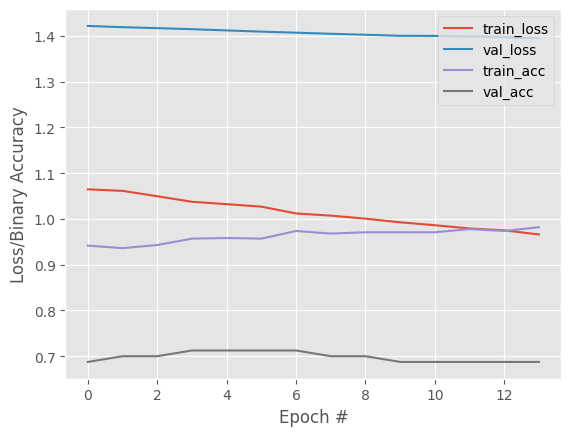

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 14), H_standar.history["loss"], label="train_loss")
plt.plot(np.arange(0, 14), H_standar.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 14), H_standar.history["binary_accuracy"], label="train_acc")
plt.plot(np.arange(0, 14), H_standar.history["val_binary_accuracy"], label="val_acc")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Binary Accuracy")
plt.legend()

7/7 [==============================] - 0s 3ms/step


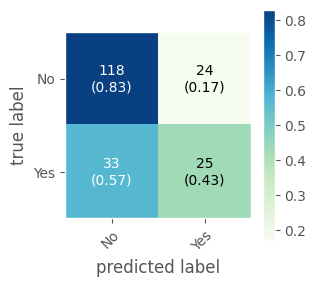

In [ ]:
predictions_rnn_standard = model_kt_standard.predict(x_test_standar).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_rnn_standard),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, predictions_rnn_standard))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       142
           1       0.51      0.43      0.47        58

    accuracy                           0.71       200
   macro avg       0.65      0.63      0.64       200
weighted avg       0.70      0.71      0.71       200



In [ ]:
model_kt_standard.evaluate(x_test_standar, y_test)[1]

7/7 [==============================] - 0s 3ms/step - loss: 1.3459 - binary_accuracy: 0.7150


0.7149999737739563

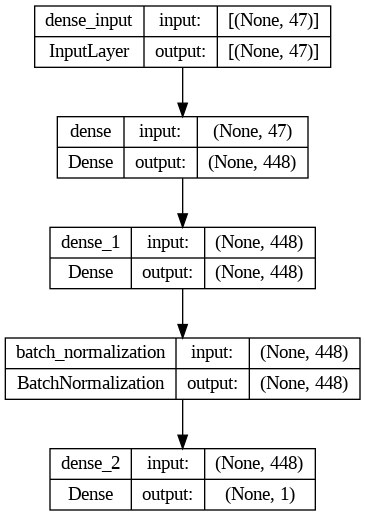

In [ ]:
plot_model(model_kt_standard, 'net.png', show_shapes=True)

In [ ]:
BASE_FOLDER = "/content/drive/MyDrive/TFM Maicol Ardila/"
drive.mount('/content/drive')

model_kt_standard.save(BASE_FOLDER+"MLP_Standard.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
#### Perceptrón Multicapa
---

---
##### Primer MLP
---

In [ ]:
epo_1 = 14
def model_builder_MLP_1(hp):
  model = Sequential()
  hp_units_1 = hp.Int('units_1', min_value = 2, max_value = 512, step = 32)
  hp_units_2 = hp.Int('units_2', min_value = 2, max_value = 512, step = 32)
  hp_units_3 = hp.Int('units_3', min_value = 2, max_value = 512, step = 32)
  hp_units_4 = hp.Int('units_4', min_value = 2, max_value = 512, step = 32)
  hp_reg_1 = hp.Choice('l2_1', values = [0.01, 0.02, 0.03])
  hp_drop = hp.Choice('rate', values = [0.25, 0.5, 0.75])
  hp_learning_rate = hp.Choice('learning_rate',
                               values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])

  model.add(Dense(units = hp_units_1, activation = 'relu', kernel_regularizer = regularizers.l2(hp_reg_1),
                  input_shape = (len(X_train.columns),)))

  model.add(Dense(units = hp_units_2, activation = 'relu'))

  model.add(BatchNormalization())

  model.add(Dense(units = hp_units_3, activation = 'relu'))

  model.add(BatchNormalization())

  model.add(Dense(units = hp_units_4, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = "binary_crossentropy", metrics = ['accuracy'])
  return model

In [ ]:
tuner_MLP_1 = kt.Hyperband(model_builder_MLP_1, objective = 'val_accuracy', max_epochs = epo_1)

In [ ]:
tuner_MLP_1.search(X_train_standar, Y_train, epochs = epo_1, validation_data = (x_val_standar, y_val))

Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.637499988079071

Best val_accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 02m 16s


In [ ]:
print("Neuronas Primera Capa: ", tuner_MLP_1.get_best_hyperparameters()[0].get('units_1'))
print("Neuronas Segunda Capa: ", tuner_MLP_1.get_best_hyperparameters()[0].get('units_2'))
print("Neuronas Tercera Capa: ", tuner_MLP_1.get_best_hyperparameters()[0].get('units_3'))
print("Neuronas Cuarta Capa: ", tuner_MLP_1.get_best_hyperparameters()[0].get('units_4'))
print("Hiperparametro Ponderador L2: ", tuner_MLP_1.get_best_hyperparameters()[0].get('l2_1'))
print("Dropout Rate: ", tuner_MLP_1.get_best_hyperparameters()[0].get('rate'))
print("Learning Rate: ", tuner_MLP_1.get_best_hyperparameters()[0].get('learning_rate'))

Neuronas Primera Capa:  34
Neuronas Segunda Capa:  226
Neuronas Tercera Capa:  322
Neuronas Cuarta Capa:  66
Hiperparametro Ponderador L2:  0.02
Dropout Rate:  0.75
Learning Rate:  0.006


In [ ]:
model_MLP_1 = tuner_MLP_1.get_best_models(num_models=1)[0]
model_MLP_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 34)                1632      
                                                                 
 dense_1 (Dense)             (None, 226)               7910      
                                                                 
 batch_normalization (BatchN  (None, 226)              904       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 322)               73094     
                                                                 
 batch_normalization_1 (Batc  (None, 322)              1288      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 66)                2

In [ ]:
H_MLP_1 = model_MLP_1.fit(X_train_standar,Y_train, epochs = epo_1, batch_size = 16,
                          validation_data=(x_val_standar, y_val))

Epoch 1/14
45/45 [==============================] - 2s 9ms/step - loss: 1.1101 - accuracy: 0.7236 - val_loss: 1.0967 - val_accuracy: 0.6375
Epoch 2/14
45/45 [==============================] - 0s 4ms/step - loss: 0.9325 - accuracy: 0.7222 - val_loss: 1.0890 - val_accuracy: 0.6250
Epoch 3/14
45/45 [==============================] - 0s 4ms/step - loss: 0.8224 - accuracy: 0.7417 - val_loss: 1.0019 - val_accuracy: 0.6250
Epoch 4/14
45/45 [==============================] - 0s 4ms/step - loss: 0.7628 - accuracy: 0.7681 - val_loss: 0.9287 - val_accuracy: 0.6250
Epoch 5/14
45/45 [==============================] - 0s 4ms/step - loss: 0.7177 - accuracy: 0.7667 - val_loss: 0.8882 - val_accuracy: 0.6625
Epoch 6/14
45/45 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.7889 - val_loss: 0.8441 - val_accuracy: 0.6000
Epoch 7/14
45/45 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.7597 - val_loss: 0.8768 - val_accuracy: 0.6250
Epoch 8/14
45/45 [==

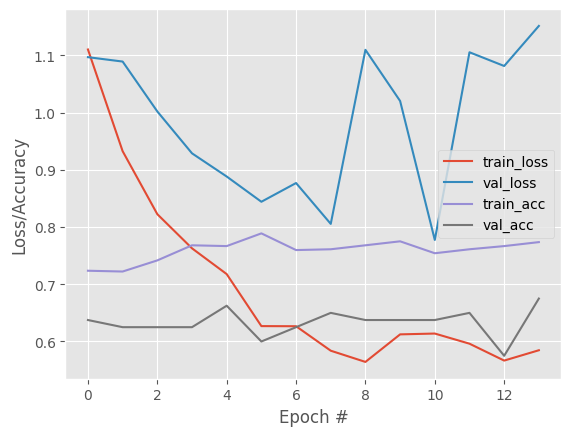

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epo_1), H_MLP_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, epo_1), H_MLP_1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epo_1), H_MLP_1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epo_1), H_MLP_1.history["val_accuracy"], label="val_acc")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

7/7 [==============================] - 0s 2ms/step


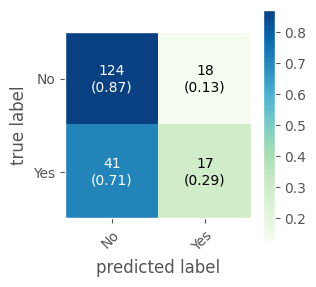

In [ ]:
predictions_perc_1 = model_MLP_1.predict(x_test_standar).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_perc_1),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
model_MLP_1.save(BASE_FOLDER+"Primer_MLP.h5")

---
##### Segundo MLP
---

In [ ]:
epo_2 = 30
def model_builder_MLP_2(hp):
  model = Sequential()
  hp_units_1 = hp.Int('units_1', min_value = 2, max_value = 512, step = 2)
  hp_units_2 = hp.Int('units_2', min_value = 2, max_value = 256, step = 2)
  hp_units_3 = hp.Int('units_3', min_value = 2, max_value = 128, step = 2)
  hp_units_4 = hp.Int('units_4', min_value = 2, max_value = 64, step = 2)
  hp_units_5 = hp.Int('units_5', min_value = 2, max_value = 32, step = 2)
  hp_units_6 = hp.Int('units_6', min_value = 2, max_value = 16, step = 2)
  hp_reg_1 = hp.Choice('l2_1', values = [0.01, 0.02, 0.03])
  hp_drop = hp.Choice('rate', values = [0.25, 0.5, 0.75])
  hp_learning_rate = hp.Choice('learning_rate',
                               values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])

  model.add(Dense(units = hp_units_1, activation = 'relu', kernel_regularizer = regularizers.l2(hp_reg_1),
                  input_shape = (len(X_train.columns),)))

  model.add(Dense(units = hp_units_2, activation = 'relu'))

  model.add(BatchNormalization())

  model.add(Dense(units = hp_units_3, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(units = hp_units_4, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(units = hp_units_5, activation = 'relu'))

  model.add(Dense(units = hp_units_6, activation = 'relu'))

  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = "binary_crossentropy", metrics = ['accuracy'])
  return model

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner_MLP_2 = kt.Hyperband(model_builder_MLP_2, objective = 'val_accuracy', max_epochs = epo_2)

In [ ]:
tuner_MLP_2.search(X_train_standar, Y_train, epochs = epo_2, validation_data = (x_val_standar, y_val),
                   callbacks=[early_stop, reduce_lr])

Trial 90 Complete [00h 00m 06s]
val_accuracy: 0.7124999761581421

Best val_accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 06m 11s


In [ ]:
print("Neuronas Primera Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_1'))
print("Neuronas Segunda Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_2'))
print("Neuronas Tercera Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_3'))
print("Neuronas Cuarta Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_4'))
print("Neuronas Quinta Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_5'))
print("Neuronas Sexta Capa: ", tuner_MLP_2.get_best_hyperparameters()[0].get('units_6'))
print("Hiperparametro Ponderador L2: ", tuner_MLP_2.get_best_hyperparameters()[0].get('l2_1'))
print("Dropout Rate: ", tuner_MLP_2.get_best_hyperparameters()[0].get('rate'))
print("Learning Rate: ", tuner_MLP_2.get_best_hyperparameters()[0].get('learning_rate'))

Neuronas Primera Capa:  102
Neuronas Segunda Capa:  36
Neuronas Tercera Capa:  112
Neuronas Cuarta Capa:  12
Neuronas Quinta Capa:  18
Neuronas Sexta Capa:  10
Hiperparametro Ponderador L2:  0.03
Dropout Rate:  0.25
Learning Rate:  0.007


In [ ]:
model_MLP_2 = tuner_MLP_2.get_best_models(num_models=1)[0]
model_MLP_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102)               4896      
                                                                 
 dense_1 (Dense)             (None, 36)                3708      
                                                                 
 batch_normalization (BatchN  (None, 36)               144       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 112)               4144      
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1356      
                                                        

In [ ]:
H_MLP_2 = model_MLP_2.fit(X_train_standar,Y_train, epochs = epo_2, batch_size = 16,
                          validation_data=(x_val_standar, y_val), callbacks=[early_stop, reduce_lr])

Epoch 1/30
45/45 [==============================] - 2s 8ms/step - loss: 0.6896 - accuracy: 0.7431 - val_loss: 0.8183 - val_accuracy: 0.6125 - lr: 0.0070
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7428 - accuracy: 0.7444 - val_loss: 0.7869 - val_accuracy: 0.6750 - lr: 0.0070
Epoch 3/30
45/45 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.7236 - val_loss: 0.7455 - val_accuracy: 0.6625 - lr: 0.0070
Epoch 4/30
45/45 [==============================] - 0s 5ms/step - loss: 0.6451 - accuracy: 0.7667 - val_loss: 0.8325 - val_accuracy: 0.6375 - lr: 0.0070
Epoch 5/30
45/45 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.7458 - val_loss: 0.8077 - val_accuracy: 0.6000 - lr: 0.0070
Epoch 6/30
45/45 [==============================] - 0s 5ms/step - loss: 0.6491 - accuracy: 0.7500 - val_loss: 0.7648 - val_accuracy: 0.6500 - lr: 0.0070


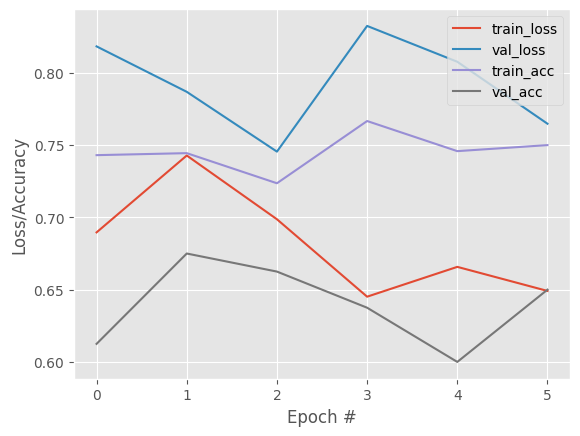

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 6), H_MLP_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 6), H_MLP_2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 6), H_MLP_2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 6), H_MLP_2.history["val_accuracy"], label="val_acc")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

7/7 [==============================] - 0s 2ms/step


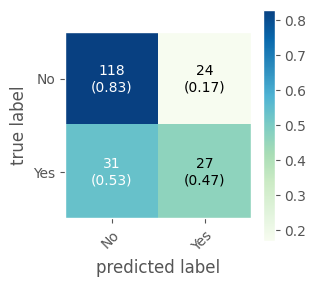

In [ ]:
predictions_perc_2 = model_MLP_2.predict(x_test_standar).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_perc_2),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
model_MLP_2.save(BASE_FOLDER+"Segundo_MLP.h5")

---
##### MLP Final
---

In [ ]:
epo = 30
def model_builder_perceptron(hp):
  model = Sequential()
  hp_units_1 = hp.Int('units_1', min_value = 2, max_value = 512, step = 2)
  hp_units_2 = hp.Int('units_2', min_value = 2, max_value = 256, step = 2)
  hp_units_3 = hp.Int('units_3', min_value = 2, max_value = 128, step = 2)
  hp_units_4 = hp.Int('units_4', min_value = 2, max_value = 64, step = 2)
  hp_units_5 = hp.Int('units_5', min_value = 2, max_value = 32, step = 2)
  hp_units_6 = hp.Int('units_6', min_value = 2, max_value = 16, step = 2)
  hp_reg_1 = hp.Choice('l2_1', values = [0.01, 0.02, 0.03])
  hp_drop = hp.Choice('rate', values = [0.25, 0.5, 0.75])
  hp_learning_rate = hp.Choice('learning_rate',
                               values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])

  model.add(Dense(units = hp_units_1, activation = 'relu', kernel_regularizer = regularizers.l2(hp_reg_1),
                  input_shape = (len(X_train.columns),)))

  model.add(Dense(units = hp_units_2, activation = 'relu'))

  model.add(BatchNormalization())

  model.add(Dense(units = hp_units_3, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(units = hp_units_4, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(units = hp_units_5, activation = 'relu'))

  model.add(Dense(units = hp_units_6, activation = 'relu'))

  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = "binary_crossentropy", metrics = ['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder_perceptron,
                     objective = 'val_accuracy',
                     max_epochs = epo)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
new_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y_train), y = Y_train)
new_weights = dict(enumerate(new_weights))
new_weights

{0: 0.7072691552062869, 1: 1.7061611374407584}

In [ ]:
tuner.search(X_train_standar, Y_train, epochs = epo, callbacks=[early_stop, reduce_lr],
             validation_data = (x_val_standar, y_val), class_weight = new_weights)

Trial 90 Complete [00h 00m 03s]
val_accuracy: 0.675000011920929

Best val_accuracy So Far: 0.737500011920929
Total elapsed time: 00h 03m 46s


In [ ]:
print("Neuronas Primera Capa: ", tuner.get_best_hyperparameters()[0].get('units_1'))
print("Neuronas Segunda Capa: ", tuner.get_best_hyperparameters()[0].get('units_2'))
print("Neuronas Tercera Capa: ", tuner.get_best_hyperparameters()[0].get('units_3'))
print("Neuronas Cuarta Capa: ", tuner.get_best_hyperparameters()[0].get('units_4'))
print("Neuronas Cuarta Capa: ", tuner.get_best_hyperparameters()[0].get('units_5'))
print("Neuronas Cuarta Capa: ", tuner.get_best_hyperparameters()[0].get('units_6'))
print("Hiperparametro Ponderador L2: ", tuner.get_best_hyperparameters()[0].get('l2_1'))
print("Dropout Rate: ", tuner.get_best_hyperparameters()[0].get('rate'))
print("Learning Rate: ", tuner.get_best_hyperparameters()[0].get('learning_rate'))

Neuronas Primera Capa:  394
Neuronas Segunda Capa:  236
Neuronas Tercera Capa:  82
Neuronas Cuarta Capa:  62
Neuronas Cuarta Capa:  18
Neuronas Cuarta Capa:  10
Hiperparametro Ponderador L2:  0.02
Dropout Rate:  0.75
Learning Rate:  0.008


In [ ]:
model_kt = tuner.get_best_models(num_models=1)[0]
model_kt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 394)               18912     
                                                                 
 dense_1 (Dense)             (None, 236)               93220     
                                                                 
 batch_normalization (BatchN  (None, 236)              944       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 82)                19434     
                                                                 
 dropout (Dropout)           (None, 82)                0         
                                                                 
 dense_3 (Dense)             (None, 62)                5146      
                                                        

In [ ]:
H = model_kt.fit(X_train_standar,Y_train, epochs=epo, batch_size = 16, callbacks=[early_stop, reduce_lr],
                 validation_data=(x_val_standar, y_val), class_weight = new_weights)

Epoch 1/30
45/45 [==============================] - 1s 7ms/step - loss: 0.8068 - accuracy: 0.6736 - val_loss: 0.8109 - val_accuracy: 0.5875 - lr: 0.0080
Epoch 2/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7643 - accuracy: 0.6625 - val_loss: 0.7828 - val_accuracy: 0.5875 - lr: 0.0080
Epoch 3/30
45/45 [==============================] - 0s 3ms/step - loss: 0.8261 - accuracy: 0.6444 - val_loss: 0.8459 - val_accuracy: 0.6375 - lr: 0.0080
Epoch 4/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7649 - accuracy: 0.6250 - val_loss: 0.7064 - val_accuracy: 0.6375 - lr: 0.0080
Epoch 5/30
45/45 [==============================] - 0s 3ms/step - loss: 0.8320 - accuracy: 0.6028 - val_loss: 0.8098 - val_accuracy: 0.5750 - lr: 0.0080
Epoch 6/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7774 - accuracy: 0.6653 - val_loss: 0.8641 - val_accuracy: 0.5500 - lr: 0.0080
Epoch 7/30
45/45 [==============================] - 0s 3ms/step - loss: 0.7608 - a

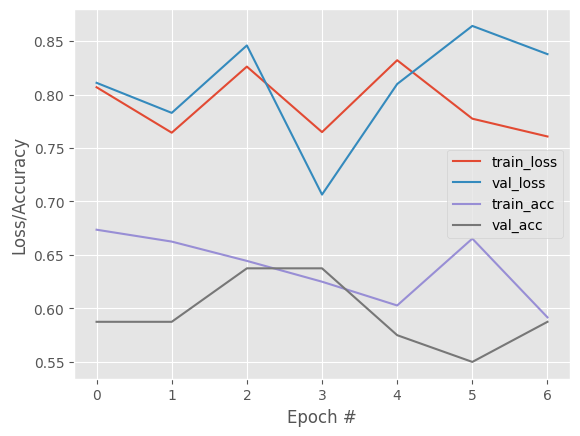

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 7), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 7), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 7), H.history["val_accuracy"], label="val_acc")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

7/7 [==============================] - 0s 2ms/step


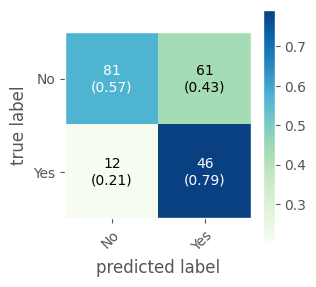

In [ ]:
predictions_perc = model_kt.predict(x_test_standar).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_perc),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, predictions_perc))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69       142
           1       0.43      0.79      0.56        58

    accuracy                           0.64       200
   macro avg       0.65      0.68      0.62       200
weighted avg       0.74      0.64      0.65       200



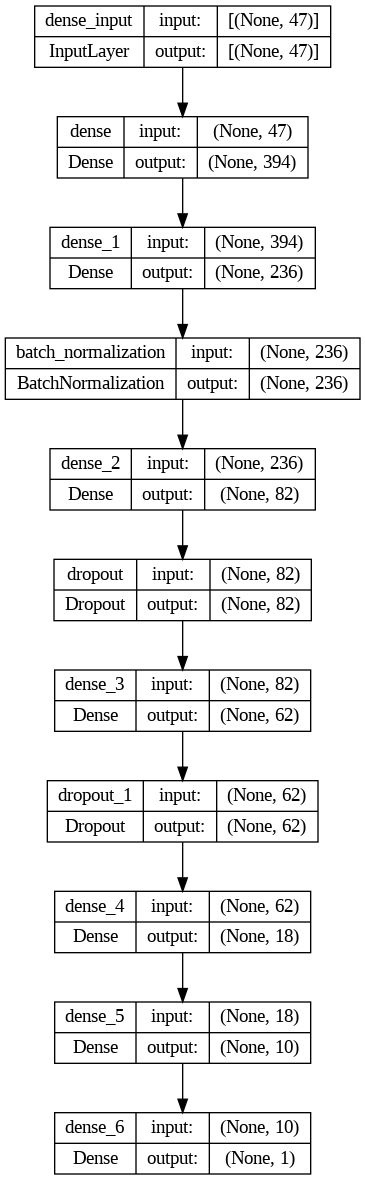

In [ ]:
plot_model(model_kt, 'net.png', show_shapes=True)

In [ ]:
model_kt.save(BASE_FOLDER+"MLP.h5")

---
## Balanceo de Clases (Smoote)
---

In [ ]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_train, Y_train)

---
### Random Forest
---

---
#### Random Search
---

In [ ]:
param_dist_forest_b = {"n_estimators": np.arange(1, 10, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "random_state": np.arange(10, 30, 1),
              "bootstrap": [True, False],
              "max_depth": np.arange(1, 20, 1),}
rnd_forest_clas_b = RandomForestClassifier()

rnd_forest_b = RandomizedSearchCV(estimator = rnd_forest_clas_b, param_distributions = param_dist_forest_b, n_iter = 100,
                                cv = 5, random_state=0, n_jobs = -1, scoring ='f1')

rnd_forest_b.fit( X = X_res, y = y_res)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'random_state': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
                   random_state=0, scoring='f1')

---
#### Grid Search
---

In [ ]:
param_dist_forest_b_2 = {"n_estimators": np.arange(7, 11, 1),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "random_state": np.arange(27, 31, 1),
              "max_depth": np.arange(12, 16, 1),}

rnd_forest_clas_b_2 = RandomForestClassifier()

grid_forest_b = GridSearchCV(estimator = rnd_forest_clas_b_2, param_grid = param_dist_forest_b_2,
                               cv = 5, scoring ='f1')

grid_forest_b.fit( X = X_res, y = y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([12, 13, 14, 15]),
                         'n_estimators': array([ 7,  8,  9, 10]),
                         'random_state': array([27, 28, 29, 30])},
             scoring='f1')

---
#### Creacion del Modelo
---

In [ ]:
Random_Forest_rnd_b = rnd_forest_b.best_estimator_
Random_Forest_rnd_b.fit( X = X_res, y = y_res)

RandomForestClassifier(criterion='log_loss', max_depth=14, n_estimators=9,
                       random_state=29)

In [ ]:
Random_Forest_grid_b = grid_forest_b.best_estimator_
Random_Forest_grid_b.fit( X = X_res, y = y_res)

RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=9,
                       random_state=29)

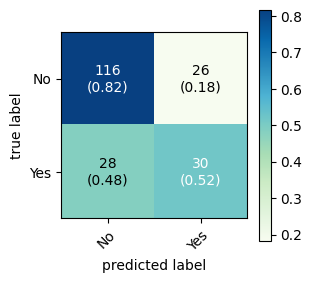

In [ ]:
predictions_forest_rnd_b = Random_Forest_rnd_b.predict(X=x_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_forest_rnd_b),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, Random_Forest_rnd_b.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.81      0.82      0.81       142
         yes       0.54      0.52      0.53        58

    accuracy                           0.73       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.73      0.73      0.73       200



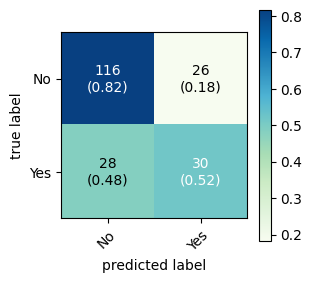

In [ ]:
predictions_forest_Grid_b = Random_Forest_grid_b.predict(X=x_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_forest_Grid_b),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, Random_Forest_grid_b.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.81      0.82      0.81       142
         yes       0.54      0.52      0.53        58

    accuracy                           0.73       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.73      0.73      0.73       200



---
### XGBoost
---

---
#### Random Search
---

In [ ]:
param_dist_XGB_b = {"max_depth": np.arange(1, 20, 1),
              "gamma": np.arange(0, 20, 1),
              "max_delta_step": np.arange(0, 20, 1),
              "eta": np.arange(0, 1, 0.1),
              }
rnd_XGB_class_b = xgb.XGBClassifier()

rnd_XGB_b = RandomizedSearchCV(estimator = rnd_XGB_class_b, param_distributions = param_dist_XGB_b, n_iter = 100,
                                cv = 5, random_state=0, n_jobs = -1, scoring ='f1')

rnd_XGB_b.fit( X = X_res, y = y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'eta': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
                                        'max_delta_step': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
                   random_state=0, scoring='f1')

In [ ]:
rnd_XGB_b.best_params_

{'max_depth': 4, 'max_delta_step': 10, 'gamma': 10, 'eta': 0.5}

---
#### Grid Search
---

In [ ]:
param_dist_XGB_b_2 = {"max_depth": np.arange(2, 6, 1),
              "gamma": np.arange(8, 12, 1),
              "max_delta_step": np.arange(8, 12, 1),
              "eta": np.arange(0.4, 0.6, 0.01),
              }
rnd_XGB_class_b_2 = xgb.XGBClassifier()

grid_XGB_b = GridSearchCV(estimator = rnd_XGB_class_b_2, param_grid = param_dist_XGB_b_2, cv = 5, scoring ='f1')

grid_XGB_b.fit( X = X_res, y = y_res)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]),
                         'gamma': array([ 8,  9, 10, 11]),
                         'max_delta_step': array([ 8,  9, 10, 11]),
                         'max_depth': array([2, 3, 4, 5])},
             scoring='f1')

In [ ]:
grid_XGB_b.best_params_
#{'eta': 0.5800000000000002, 'gamma': 2, 'max_delta_step': 1, 'max_depth': 1}

{'eta': 0.5000000000000001, 'gamma': 10, 'max_delta_step': 8, 'max_depth': 4}

---
#### Creacion del Modelo
---

In [ ]:
evalset = [(X_res, y_res), (x_val,y_val)]

In [ ]:
XBG_rnd_b = rnd_XGB_b.best_estimator_
XBG_rnd_b.fit( X = X_res, y = y_res, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.21513	validation_1-error:0.43750
[1]	validation_0-error:0.16896	validation_1-error:0.35000
[2]	validation_0-error:0.17485	validation_1-error:0.33750
[3]	validation_0-error:0.15324	validation_1-error:0.37500
[4]	validation_0-error:0.16110	validation_1-error:0.37500
[5]	validation_0-error:0.15226	validation_1-error:0.35000
[6]	validation_0-error:0.15226	validation_1-error:0.35000
[7]	validation_0-error:0.15226	validation_1-error:0.35000
[8]	validation_0-error:0.15226	validation_1-error:0.35000
[9]	validation_0-error:0.15226	validation_1-error:0.35000
[10]	validation_0-error:0.15226	validation_1-error:0.35000
[11]	validation_0-error:0.15226	validation_1-error:0.35000
[12]	validation_0-error:0.15226	validation_1-error:0.35000
[13]	validation_0-error:0.15226	validation_1-error:0.35000
[14]	validation_0-error:0.15226	validation_1-error:0.35000
[15]	validation_0-error:0.15226	validation_1-error:0.35000
[16]	validation_0-error:0.15226	validation_1-error:0.35000
[17]	va

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-error:0.15226	validation_1-error:0.35000
[26]	validation_0-error:0.15226	validation_1-error:0.35000
[27]	validation_0-error:0.15226	validation_1-error:0.35000
[28]	validation_0-error:0.15226	validation_1-error:0.35000
[29]	validation_0-error:0.15226	validation_1-error:0.35000
[30]	validation_0-error:0.15226	validation_1-error:0.35000
[31]	validation_0-error:0.15226	validation_1-error:0.35000
[32]	validation_0-error:0.15226	validation_1-error:0.35000
[33]	validation_0-error:0.15226	validation_1-error:0.35000
[34]	validation_0-error:0.15226	validation_1-error:0.35000
[35]	validation_0-error:0.15226	validation_1-error:0.35000
[36]	validation_0-error:0.15226	validation_1-error:0.35000
[37]	validation_0-error:0.15226	validation_1-error:0.35000
[38]	validation_0-error:0.15226	validation_1-error:0.35000
[39]	validation_0-error:0.15226	validation_1-error:0.35000
[40]	validation_0-error:0.15226	validation_1-error:0.35000
[41]	validation_0-error:0.15226	validation_1-error:0.350

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5, eval_metric=None,
              feature_types=None, gamma=10, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=10, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
XBG_grid_b = grid_XGB_b.best_estimator_
XBG_grid_b.fit( X = X_res, y = y_res, eval_metric ='error', eval_set = evalset)

[0]	validation_0-error:0.21513	validation_1-error:0.43750
[1]	validation_0-error:0.16896	validation_1-error:0.35000
[2]	validation_0-error:0.17485	validation_1-error:0.33750
[3]	validation_0-error:0.15324	validation_1-error:0.37500
[4]	validation_0-error:0.16110	validation_1-error:0.37500
[5]	validation_0-error:0.15226	validation_1-error:0.35000
[6]	validation_0-error:0.15226	validation_1-error:0.35000
[7]	validation_0-error:0.15226	validation_1-error:0.35000
[8]	validation_0-error:0.15226	validation_1-error:0.35000
[9]	validation_0-error:0.15226	validation_1-error:0.35000
[10]	validation_0-error:0.15226	validation_1-error:0.35000
[11]	validation_0-error:0.15226	validation_1-error:0.35000
[12]	validation_0-error:0.15226	validation_1-error:0.35000
[13]	validation_0-error:0.15226	validation_1-error:0.35000
[14]	validation_0-error:0.15226	validation_1-error:0.35000
[15]	validation_0-error:0.15226	validation_1-error:0.35000
[16]	validation_0-error:0.15226	validation_1-error:0.35000
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5000000000000001,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=8,
              max_depth=4, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

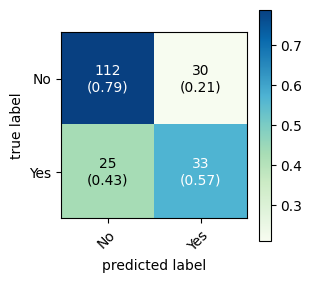

In [ ]:
predictions_XGBoost_rnd_b = XBG_rnd_b.predict(X=x_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_rnd_b),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_rnd_b.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.82      0.79      0.80       142
         yes       0.52      0.57      0.55        58

    accuracy                           0.73       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.73      0.72      0.73       200



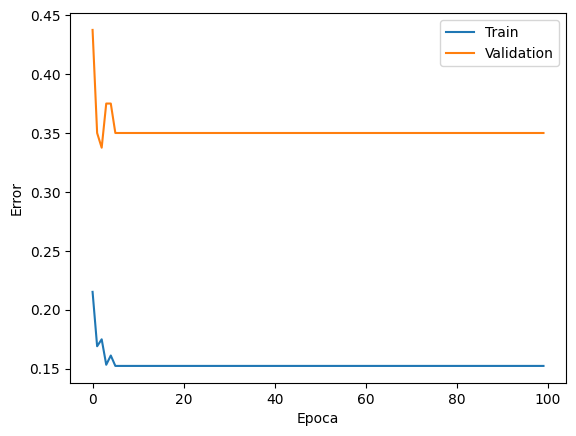

In [ ]:
results_rnd = XBG_rnd_b.evals_result()
plt.plot(results_rnd['validation_0']['error'], label='Train')
plt.plot(results_rnd['validation_1']['error'], label='Validation')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()
plt.show()

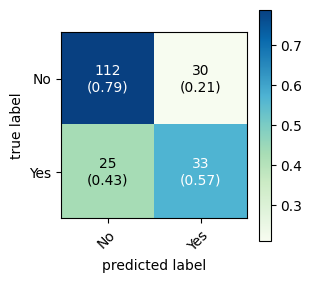

In [ ]:
predictions_XGBoost_grid_b = XBG_grid_b.predict(X=x_test)

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_XGBoost_grid_b),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, XBG_grid_b.predict(x_test), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.82      0.79      0.80       142
         yes       0.52      0.57      0.55        58

    accuracy                           0.73       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.73      0.72      0.73       200



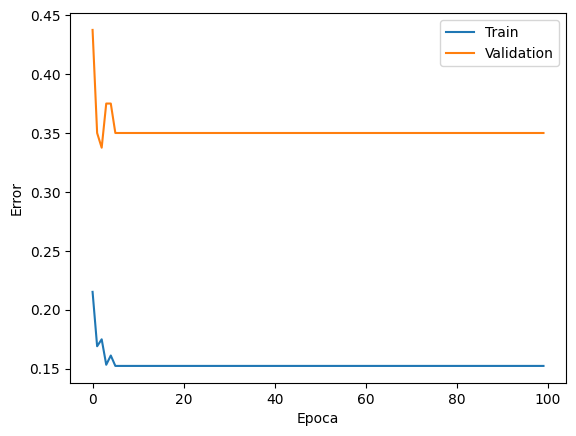

In [ ]:
results_grid = XBG_grid_b.evals_result()
plt.plot(results_grid['validation_0']['error'], label='Train')
plt.plot(results_grid['validation_1']['error'], label='Validation')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()
plt.show()

---
### Red Neuronal
---

In [ ]:
standard_scaler_b = preprocessing.StandardScaler()

In [ ]:
columns = X_train.columns
standard_scaler_b.fit(X_train[columns])

############## ------------------- X_train ------------------- ##############

train_norm_standar_b = standard_scaler_b.transform(X_res[columns])
X_train_standar = pd.DataFrame(train_norm_standar_b)

############## ------------------- x_val ------------------- ##############

val_norm_standar_b = standard_scaler_b.transform(x_val[columns])
x_val_standar = pd.DataFrame(val_norm_standar_b)

############## ------------------- x_test ------------------- ##############

test_norm_standar_b = standard_scaler_b.transform(x_test[columns])
x_test_standar= pd.DataFrame(test_norm_standar_b)

In [ ]:
epo_1 = 14
def model_builder_MLP_b(hp):
  model = Sequential()
  hp_units_1 = hp.Int('units_1', min_value = 2, max_value = 512, step = 32)
  hp_units_2 = hp.Int('units_2', min_value = 2, max_value = 512, step = 32)
  hp_units_3 = hp.Int('units_3', min_value = 2, max_value = 512, step = 32)
  hp_units_4 = hp.Int('units_4', min_value = 2, max_value = 512, step = 32)
  #hp_reg_1 = hp.Choice('l2_1', values = [0.01, 0.02, 0.03])
  hp_drop = hp.Choice('rate', values = [0.25, 0.5, 0.75])
  hp_learning_rate = hp.Choice('learning_rate',
                               values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])

  #model.add(Dense(units = hp_units_1, activation = 'relu', kernel_regularizer = regularizers.l2(hp_reg_1),
  #                input_shape = (len(X_train.columns),)))
  model.add(Dense(units = hp_units_1, activation = 'relu', input_shape = (len(X_train.columns),)))

  model.add(Dense(units = hp_units_2, activation = 'relu'))

  model.add(BatchNormalization())

  model.add(Dense(units = hp_units_3, activation = 'relu'))

  model.add(Dense(units = hp_units_4, activation = 'relu'))

  model.add(Dropout(hp_drop))

  model.add(Dense(1, activation="sigmoid"))

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = "binary_crossentropy", metrics = ['accuracy'])
  return model

In [ ]:
tuner_standard = kt.Hyperband(model_builder_MLP_b,
                     objective = 'val_binary_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
tuner_MLP_b = kt.Hyperband(model_builder_MLP_b, objective = 'val_accuracy', max_epochs = epo_1)
tuner_MLP_b.search(X_train_standar, y_res, epochs = epo_1, validation_data = (x_val_standar, y_val))

Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.675000011920929

Best val_accuracy So Far: 0.7124999761581421
Total elapsed time: 00h 02m 38s


In [ ]:
print("Neuronas Primera Capa: ", tuner_MLP_b.get_best_hyperparameters()[0].get('units_1'))
print("Neuronas Segunda Capa: ", tuner_MLP_b.get_best_hyperparameters()[0].get('units_2'))
print("Neuronas Tercera Capa: ", tuner_MLP_b.get_best_hyperparameters()[0].get('units_3'))
print("Neuronas Cuarta Capa: ", tuner_MLP_b.get_best_hyperparameters()[0].get('units_4'))
#print("Hiperparametro Ponderador L2: ", tuner_MLP_b.get_best_hyperparameters()[0].get('l2_1'))
print("Dropout Rate: ", tuner_MLP_b.get_best_hyperparameters()[0].get('rate'))
print("Learning Rate: ", tuner_MLP_b.get_best_hyperparameters()[0].get('learning_rate'))

Neuronas Primera Capa:  194
Neuronas Segunda Capa:  258
Neuronas Tercera Capa:  482
Neuronas Cuarta Capa:  2
Dropout Rate:  0.5
Learning Rate:  0.005


In [ ]:
model_MLP_b = tuner_MLP_b.get_best_models(num_models=1)[0]
model_MLP_b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 194)               9312      
                                                                 
 dense_1 (Dense)             (None, 258)               50310     
                                                                 
 batch_normalization (BatchN  (None, 258)              1032      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 482)               124838    
                                                                 
 dense_3 (Dense)             (None, 2)                 966       
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                        

In [ ]:
H_MLP_b = model_MLP_b.fit(X_train_standar,y_res, epochs = epo_1, batch_size = 16,
                          validation_data=(x_val_standar, y_val))

Epoch 1/14
64/64 [==============================] - 3s 16ms/step - loss: 0.6300 - accuracy: 0.6621 - val_loss: 0.6677 - val_accuracy: 0.5250
Epoch 2/14
64/64 [==============================] - 1s 11ms/step - loss: 0.6263 - accuracy: 0.6523 - val_loss: 0.8895 - val_accuracy: 0.6000
Epoch 3/14
64/64 [==============================] - 1s 10ms/step - loss: 0.5986 - accuracy: 0.6807 - val_loss: 0.6388 - val_accuracy: 0.6250
Epoch 4/14
64/64 [==============================] - 1s 9ms/step - loss: 0.6222 - accuracy: 0.6454 - val_loss: 0.6631 - val_accuracy: 0.6375
Epoch 5/14
64/64 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.6336 - val_loss: 0.6416 - val_accuracy: 0.6000
Epoch 6/14
64/64 [==============================] - 0s 8ms/step - loss: 0.5899 - accuracy: 0.6690 - val_loss: 0.5853 - val_accuracy: 0.6250
Epoch 7/14
64/64 [==============================] - 0s 7ms/step - loss: 0.6185 - accuracy: 0.6631 - val_loss: 0.6061 - val_accuracy: 0.6500
Epoch 8/14
64/64 

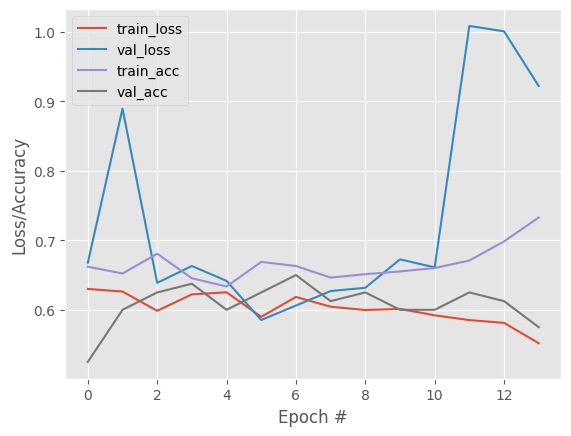

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epo_1), H_MLP_b.history["loss"], label="train_loss")
plt.plot(np.arange(0, epo_1), H_MLP_b.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epo_1), H_MLP_b.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epo_1), H_MLP_b.history["val_accuracy"], label="val_acc")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

7/7 [==============================] - 0s 3ms/step


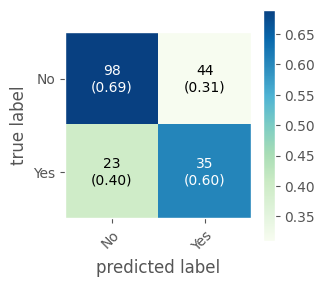

In [ ]:
predictions_perc_b = model_MLP_b.predict(x_test_standar).round()

fig, ax = plot_confusion_matrix(show_absolute=True,
                                show_normed=True, conf_mat=confusion_matrix(y_test, predictions_perc_b),
                                colorbar=True, cmap = 'GnBu', figsize = (3,3), class_names=['No', 'Yes'])
plt.show()

In [ ]:
print(classification_report(y_test, predictions_perc_b))

              precision    recall  f1-score   support

           0       0.81      0.69      0.75       142
           1       0.44      0.60      0.51        58

    accuracy                           0.67       200
   macro avg       0.63      0.65      0.63       200
weighted avg       0.70      0.67      0.68       200



---
## Interpretabilidad de los Modelos
---

---
### Random Forest
---

In [ ]:
exp_forest = dx.Explainer(Random_Forest_rnd_b, X_res, y_res)

Preparation of a new explainer is initiated

  -> data              : 1018 rows 47 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1018 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7d330e7b3640> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.507, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.769, mean = -0.00691, max = 0.556
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [ ]:
exp_forest.model_parts().plot()

In [ ]:
exp_forest.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 47/47 [00:05<00:00,  8.79it/s]


In [ ]:
n = random.randint(0, len(x_test)-1)
print(n)
sample_Forest = pd.DataFrame(x_test.iloc[n]).T
sample_Forest

74


months_loan_duration  amount  years_at_residence  age  \
926                    18    1049                   4   21   

     existing_loans_count  dependents  checking_balance_1 - 200 DM  \
926                     1           1                            0   

     checking_balance_ 0 DM  checking_balance_ 200 DM  \
926                       1                         0   

     checking_balance_unknown  credit_history_critical  credit_history_good  \
926                         0                        1                    0   

     credit_history_perfect  credit_history_poor  credit_history_very good  \
926                       0                    0                         0   

     purpose_business  purpose_car  purpose_car0  purpose_education  \
926                 0            0             0                  0   

     purpose_furniture/appliances  purpose_renovations  \
926                             1                    0   

     savings_balance_100 - 500 DM  savings_balance_500 - 1000 DM  \
926                             0                              0   

     savings_balance_ 100 DM  savings_balance_ 1000 DM  \
926                        1                         0   

     savings_balance_unknown  employment_duration_1 - 4 years  \
926                        0                                0   

     employment_duration_4 - 7 years  employment_duration_ 1 year  \
926                                0                            1   

     employment_duration_ 7 years  employment_duration_unemployed  \
926                             0                               0   

     percent_of_income_1  percent_of_income_2  percent_of_income_3  \
926                    0                    0                    0   

     percent_of_income_4  other_credit_bank  other_credit_none  \
926                    1                  0                  1   

     other_credit_store  housing_other  housing_own  housing_rent  \
926                   0              0            0             1   

     job_management  job_skilled  job_unemployed  job_unskilled  phone_no  \
926               0            1               0              0         1   

     phone_yes  
926          0

In [ ]:
exp_forest.predict_parts(sample_Forest).plot()

In [ ]:
pd.DataFrame(y_test).reset_index(drop=True).iloc[n_Forest]

default    0
Name: 74, dtype: int64

---
### XGBoost
---

In [ ]:
exp_XGBoost = dx.Explainer(XBG_grid_b, X_res, y_res)

Preparation of a new explainer is initiated

  -> data              : 1018 rows 47 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1018 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7b4b48bf9480> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0577, mean = 0.5, max = 0.947
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.843, mean = -8.45e-10, max = 0.918
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
exp_XGBoost.model_parts().plot()

In [ ]:
exp_XGBoost.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 47/47 [00:02<00:00, 23.42it/s]


In [ ]:
sample_XGBoost = pd.DataFrame(x_test.iloc[n]).T
sample_XGBoost

74


months_loan_duration  amount  years_at_residence  age  \
926                    18    1049                   4   21   

     existing_loans_count  dependents  checking_balance_1 - 200 DM  \
926                     1           1                            0   

     checking_balance_ 0 DM  checking_balance_ 200 DM  \
926                       1                         0   

     checking_balance_unknown  credit_history_critical  credit_history_good  \
926                         0                        1                    0   

     credit_history_perfect  credit_history_poor  credit_history_very good  \
926                       0                    0                         0   

     purpose_business  purpose_car  purpose_car0  purpose_education  \
926                 0            0             0                  0   

     purpose_furniture/appliances  purpose_renovations  \
926                             1                    0   

     savings_balance_100 - 500 DM  savings_balance_500 - 1000 DM  \
926                             0                              0   

     savings_balance_ 100 DM  savings_balance_ 1000 DM  \
926                        1                         0   

     savings_balance_unknown  employment_duration_1 - 4 years  \
926                        0                                0   

     employment_duration_4 - 7 years  employment_duration_ 1 year  \
926                                0                            1   

     employment_duration_ 7 years  employment_duration_unemployed  \
926                             0                               0   

     percent_of_income_1  percent_of_income_2  percent_of_income_3  \
926                    0                    0                    0   

     percent_of_income_4  other_credit_bank  other_credit_none  \
926                    1                  0                  1   

     other_credit_store  housing_other  housing_own  housing_rent  \
926                   0              0            0             1   

     job_management  job_skilled  job_unemployed  job_unskilled  phone_no  \
926               0            1               0              0         1   

     phone_yes  
926          0

In [ ]:
exp_XGBoost.predict_parts(sample_XGBoost).plot()

---
### Red Neuronal MLP
---

In [ ]:
# Cargar la red Neuronal que se creo anteriormente

MLP_model = load_model(BASE_FOLDER+'MLP.h5')

In [ ]:
exp_MLP = dx.Explainer(MLP_model, X_train_standar, Y_train)

Preparation of a new explainer is initiated

  -> data              : 720 rows 47 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 720 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_tf_regression at 0x7b4b48bf9630> will be used (default)
1/1 [==============================] - 0s 247ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
23/23 [==============================] - 0s 3ms/step
  -> predicted values  : min = 0.153, mean = 0.543, max = 0.968
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
23/23 [==============================] - 0s 2ms/step
  -> residuals         : min = -0.963, mean = -0.25, max = 0.613
  -> model_info        : package keras

A new expla

In [ ]:
exp_MLP.model_parts().plot()

23/23 [==============================] - 0s 4ms/step


In [ ]:
exp_MLP.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/47 [00:00<?, ?it/s]

947/947 [==============================] - 5s 5ms/step


Calculating ceteris paribus:   2%|▏         | 1/47 [00:06<05:02,  6.58s/it]

947/947 [==============================] - 7s 8ms/step


Calculating ceteris paribus:   4%|▍         | 2/47 [00:15<05:48,  7.75s/it]

947/947 [==============================] - 5s 5ms/step


Calculating ceteris paribus:   6%|▋         | 3/47 [00:20<04:55,  6.72s/it]

947/947 [==============================] - 7s 7ms/step


Calculating ceteris paribus:   9%|▊         | 4/47 [00:31<05:52,  8.20s/it]

947/947 [==============================] - 5s 5ms/step


Calculating ceteris paribus:  11%|█         | 5/47 [00:41<06:18,  9.00s/it]

947/947 [==============================] - 6s 7ms/step


Calculating ceteris paribus:  13%|█▎        | 6/47 [00:52<06:30,  9.52s/it]

947/947 [==============================] - 5s 6ms/step


Calculating ceteris paribus:  15%|█▍        | 7/47 [00:59<05:51,  8.78s/it]

947/947 [==============================] - 6s 6ms/step


Calculating ceteris paribus:  17%|█▋        | 8/47 [01:06<05:24,  8.33s/it]

947/947 [==============================] - 5s 6ms/step


Calculating ceteris paribus:  19%|█▉        | 9/47 [01:17<05:41,  8.98s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  21%|██▏       | 10/47 [01:22<04:49,  7.82s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  23%|██▎       | 11/47 [01:27<04:12,  7.01s/it]

947/947 [==============================] - 3s 4ms/step


Calculating ceteris paribus:  26%|██▌       | 12/47 [01:31<03:31,  6.04s/it]

947/947 [==============================] - 2s 2ms/step


Calculating ceteris paribus:  28%|██▊       | 13/47 [01:36<03:16,  5.79s/it]

947/947 [==============================] - 2s 2ms/step


Calculating ceteris paribus:  30%|██▉       | 14/47 [01:39<02:38,  4.81s/it]

947/947 [==============================] - 4s 4ms/step


Calculating ceteris paribus:  32%|███▏      | 15/47 [01:44<02:37,  4.93s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  34%|███▍      | 16/47 [01:47<02:16,  4.41s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  36%|███▌      | 17/47 [01:52<02:19,  4.64s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  38%|███▊      | 18/47 [01:57<02:19,  4.81s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  40%|████      | 19/47 [02:00<01:59,  4.28s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  43%|████▎     | 20/47 [02:06<02:03,  4.56s/it]

947/947 [==============================] - 2s 2ms/step


Calculating ceteris paribus:  45%|████▍     | 21/47 [02:08<01:43,  3.98s/it]

947/947 [==============================] - 4s 4ms/step


Calculating ceteris paribus:  47%|████▋     | 22/47 [02:14<01:49,  4.37s/it]

947/947 [==============================] - 2s 2ms/step


Calculating ceteris paribus:  49%|████▉     | 23/47 [02:16<01:32,  3.87s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  51%|█████     | 24/47 [02:19<01:21,  3.56s/it]

947/947 [==============================] - 2s 2ms/step


Calculating ceteris paribus:  53%|█████▎    | 25/47 [02:24<01:29,  4.05s/it]

947/947 [==============================] - 3s 4ms/step


Calculating ceteris paribus:  55%|█████▌    | 26/47 [02:30<01:32,  4.41s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  57%|█████▋    | 27/47 [02:35<01:32,  4.65s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  60%|█████▉    | 28/47 [02:40<01:31,  4.81s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  62%|██████▏   | 29/47 [02:43<01:16,  4.28s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  64%|██████▍   | 30/47 [02:46<01:05,  3.86s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  66%|██████▌   | 31/47 [02:49<00:56,  3.54s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  68%|██████▊   | 32/47 [02:54<01:00,  4.05s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  70%|███████   | 33/47 [02:59<01:01,  4.40s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  72%|███████▏  | 34/47 [03:03<00:54,  4.18s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  74%|███████▍  | 35/47 [03:08<00:53,  4.48s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  77%|███████▋  | 36/47 [03:13<00:51,  4.72s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  79%|███████▊  | 37/47 [03:18<00:48,  4.86s/it]

947/947 [==============================] - 3s 4ms/step


Calculating ceteris paribus:  81%|████████  | 38/47 [03:22<00:41,  4.63s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  83%|████████▎ | 39/47 [03:26<00:33,  4.18s/it]

947/947 [==============================] - 4s 4ms/step


Calculating ceteris paribus:  85%|████████▌ | 40/47 [03:30<00:29,  4.14s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  87%|████████▋ | 41/47 [03:35<00:26,  4.46s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  89%|████████▉ | 42/47 [03:38<00:20,  4.19s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  91%|█████████▏| 43/47 [03:41<00:15,  3.78s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus:  94%|█████████▎| 44/47 [03:46<00:12,  4.21s/it]

947/947 [==============================] - 3s 4ms/step


Calculating ceteris paribus:  96%|█████████▌| 45/47 [03:50<00:08,  4.12s/it]

947/947 [==============================] - 3s 3ms/step


Calculating ceteris paribus:  98%|█████████▊| 46/47 [03:56<00:04,  4.46s/it]

947/947 [==============================] - 2s 3ms/step


Calculating ceteris paribus: 100%|██████████| 47/47 [04:01<00:00,  5.13s/it]


10/10 [==============================] - 0s 4ms/step


In [ ]:
#n_MLP = random.randint(0, len(x_test_standar)-1)
n=74
print(n)
sample_MLP = pd.DataFrame(x_test_standar.iloc[n]).T
sample_MLP

74


0        1         2         3         4         5         6   \
74 -0.222015 -0.76708  1.046886 -1.285184 -0.721039 -0.415498 -0.607307   

          7         8         9         10        11        12        13  \
74  1.640825 -0.261246 -0.809427  1.522489 -1.048392 -0.208514 -0.306961   

          14        15        16        17        18        19        20  \
74 -0.222627 -0.338454 -0.678562 -0.124558 -0.261246  1.039675 -0.150756   

          21        22        23        24     25        26        27  \
74 -0.328165 -0.267261  0.814136 -0.229416 -0.476 -0.731561 -0.453905   

          28        29        30        31        32       33        34  \
74  2.258693 -0.596601 -0.239309 -0.373149 -0.564519 -0.42237  1.031037   

          35        36        37        38        39        40        41  \
74 -0.406262  0.484759 -0.226042 -0.340997 -1.584991  2.130367 -0.403939   

          42        43        44       45       46  
74  0.758612 -0.155506 -0.502169  0.82598 -0.82598

In [ ]:
exp_MLP.predict_parts(sample_MLP).plot()

23/23 [==============================] - 0s 2ms/step


---
## Bibliografia
---

In [ ]:
# https://www.aprendemachinelearning.com/regresion-logistica-con-python-paso-a-paso/
# https://stackoverflow.com/questions/69061767/how-to-plot-feature-importance-for-decisiontreeclassifier
# https://www.datatechnotes.com/2019/07/classification-example-with.html
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h-booster-parameters